**Заголовок:** Отбор коров для молочного хозяйства «Вольный луг»

**Описание проекта:** Владелец молочного хозяйства «Вольный луг» хочет расширить поголовье стада коров.
Условия контракта с ассоциацией пастбищ «ЭкоФерма» позволяют фермеру очень тщательно отобрать коров. 
«ЭкоФерма» готова предоставить подробные данные о своих коровах.
С использованием этих данных пердстоит разработать модель машинного обучения для помощи в отборе коров.

**Цель исследования:** разработать две модели, которые помогут фермеру управлять рисками и принимать объективное решение о покупке:
- модель для прогнозирования возможного удоя коровы (целевой признак Удой — в среднем за год не менее 6000 килограммов);
- модель для расчёта вероятности получить вкусное молоко от коровы (целевой признак Вкус молока — молоко должно быть вкусным).

**Ход исследования:** 

- Предобработка данных 
    - пропуски
    - дубликаты
    - типы данных

- Исследовательский анализ данных 
    - статистический анализ признаков
    - графики
    - аномалии и выбросы

- Корреляционный анализ 
    - коэффициенты корреляции
    - диаграммы рассеяния

- Обучение модели линейной регрессии
    - только стандартизация и one-hot кодирование исходных данных
    - устранение нелинейности (СПО - удой)
    - конкретный папа бык вместо породы

- Обучение модели логистической регрессии
    - выбор порога для соответствия задаче

- Итоговые выводы

## Библиотеки

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,\
                            accuracy_score, precision_score, recall_score, confusion_matrix

## Загрузка данных

In [2]:
def load_data(
    bname,
    *args,
    **kwargs
):
    df = pd.read_csv(
        f'{bname}.csv',
        *args,
        **kwargs
    )
    
    df.columns.name = bname
    
    display(df.info())
    display(df.head())
    
    return df

In [3]:
ferma_main = load_data('ferma_main', sep=';', decimal=',')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

None

ferma_main  id  Удой, кг  ЭКЕ (Энергетическая кормовая единица)  \
0            1      5863                                   14.2   
1            2      5529                                   12.8   
2            3      5810                                   14.0   
3            4      5895                                   12.4   
4            5      5302                                   12.8   

ferma_main  Сырой протеин, г  СПО (Сахаро-протеиновое соотношение)  \
0                       1743                                 0.890   
1                       2138                                 0.890   
2                       1854                                 0.885   
3                       2012                                 0.885   
4                       1675                                 0.885   

ferma_main           Порода Тип пастбища порода папы_быка  Жирность,%  \
0            Вис Бик Айдиал    Равнинное           Айдиал        3.58   
1            Вис Бик Айдиал    Равнинные          Соверин        3.54   
2           РефлешнСоверинг    Холмистое          Соверин        3.59   
3           РефлешнСоверинг    Холмистое           Айдиал        3.40   
4            Вис Бик Айдиал    Равнинные          Соверин        3.73   

ferma_main  Белок,% Вкус молока      Возраст  
0             3.076      вкусно  более_2_лет  
1             3.079      вкусно  менее_2_лет  
2             3.074   не вкусно  более_2_лет  
3             3.075   не вкусно  более_2_лет  
4             3.073      вкусно  менее_2_лет

In [4]:
ferma_main = ferma_main.rename(
    columns={
        'Удой, кг': 'удой_кг',
        'ЭКЕ (Энергетическая кормовая единица)': 'эке',
        'Сырой протеин, г': 'протеин_г',
        'СПО (Сахаро-протеиновое соотношение)': 'спо',
        'Порода': 'порода',
        'Тип пастбища': 'пастбище',
        'порода папы_быка': 'порода_папы',
        'Жирность,%': 'жирность_%',
        'Белок,%': 'белок_%',
        'Вкус молока': 'вкус',
        'Возраст': 'возраст_2+'
    }
)

ferma_main.head()

ferma_main  id  удой_кг   эке  протеин_г    спо           порода   пастбище  \
0            1     5863  14.2       1743  0.890   Вис Бик Айдиал  Равнинное   
1            2     5529  12.8       2138  0.890   Вис Бик Айдиал  Равнинные   
2            3     5810  14.0       1854  0.885  РефлешнСоверинг  Холмистое   
3            4     5895  12.4       2012  0.885  РефлешнСоверинг  Холмистое   
4            5     5302  12.8       1675  0.885   Вис Бик Айдиал  Равнинные   

ferma_main порода_папы  жирность_%  белок_%       вкус   возраст_2+  
0               Айдиал        3.58    3.076     вкусно  более_2_лет  
1              Соверин        3.54    3.079     вкусно  менее_2_лет  
2              Соверин        3.59    3.074  не вкусно  более_2_лет  
3               Айдиал        3.40    3.075  не вкусно  более_2_лет  
4              Соверин        3.73    3.073     вкусно  менее_2_лет

In [5]:
ferma_dad = load_data('ferma_dad', sep=';')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


None

ferma_dad  id  Имя Папы
0           1    Буйный
1           2  Соловчик
2           3     Барин
3           4    Буйный
4           5     Барин

In [6]:
ferma_dad = ferma_dad.rename(columns={'Имя Папы': 'имя_папы'})

ferma_dad.head()

ferma_dad  id  имя_папы
0           1    Буйный
1           2  Соловчик
2           3     Барин
3           4    Буйный
4           5     Барин

In [7]:
cow_buy = load_data('cow_buy', sep=';', decimal=',')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


None

cow_buy           Порода Тип пастбища порода папы_быка  Имя_папы  \
0         Вис Бик Айдиал    холмистое           Айдиал  Геркулес   
1         Вис Бик Айдиал    равнинное          Соверин    Буйный   
2        РефлешнСоверинг    равнинное          Соверин     Барин   
3        РефлешнСоверинг    холмистое           Айдиал    Буйный   
4        РефлешнСоверинг    равнинное           Айдиал    Буйный   

cow_buy  Текущая_жирность,%  Текущий_уровень_белок,%      Возраст  
0                      3.58                    3.076  более_2_лет  
1                      3.54                    3.081  менее_2_лет  
2                      3.59                    3.074  более_2_лет  
3                      3.40                    3.061  более_2_лет  
4                      3.64                    3.074  более_2_лет

In [8]:
cow_buy = cow_buy.rename(
    columns={
        'Порода': 'порода',
        'Тип пастбища': 'пастбище',
        'порода папы_быка': 'порода_папы',
        'Имя_папы': 'имя_папы',
        'Текущая_жирность,%': 'жирность_%',
        'Текущий_уровень_белок,%': 'белок_%',
        'Возраст': 'возраст_2+'
    }
)

cow_buy.head()

cow_buy           порода   пастбище порода_папы  имя_папы  жирность_%  \
0         Вис Бик Айдиал  холмистое      Айдиал  Геркулес        3.58   
1         Вис Бик Айдиал  равнинное     Соверин    Буйный        3.54   
2        РефлешнСоверинг  равнинное     Соверин     Барин        3.59   
3        РефлешнСоверинг  холмистое      Айдиал    Буйный        3.40   
4        РефлешнСоверинг  равнинное      Айдиал    Буйный        3.64   

cow_buy  белок_%   возраст_2+  
0          3.076  более_2_лет  
1          3.081  менее_2_лет  
2          3.074  более_2_лет  
3          3.061  более_2_лет  
4          3.074  более_2_лет

### Итог

Столбцы потребовалось переименовать, типы определяются корректно, пропуски отсутствуют.

##  Предобработка данных

Пропусков нет, остаётся скорректировать типы и проверить на дубликаты

### Дубликаты

In [9]:
for df in [ferma_main, ferma_dad, cow_buy]:
    print(df.columns.name, ':', df.duplicated().sum())

ferma_main : 5
ferma_dad : 0
cow_buy : 4


В ferma_main есть id, по которому можно определить дубликат, а в cow_buy есть только признаки, которые могут и совпасть. Оставим cow_buy без изменений.

In [10]:
ferma_main = ferma_main.drop_duplicates().reset_index(drop=True)

### Типы данных

In [11]:
ferma_main['вкус'] = ferma_main['вкус'].apply(lambda x: x == 'вкусно')

ferma_main['возраст_2+'] = ferma_main['возраст_2+'].apply(lambda x: x == 'более_2_лет')

ferma_main.head()

ferma_main  id  удой_кг   эке  протеин_г    спо           порода   пастбище  \
0            1     5863  14.2       1743  0.890   Вис Бик Айдиал  Равнинное   
1            2     5529  12.8       2138  0.890   Вис Бик Айдиал  Равнинные   
2            3     5810  14.0       1854  0.885  РефлешнСоверинг  Холмистое   
3            4     5895  12.4       2012  0.885  РефлешнСоверинг  Холмистое   
4            5     5302  12.8       1675  0.885   Вис Бик Айдиал  Равнинные   

ferma_main порода_папы  жирность_%  белок_%   вкус  возраст_2+  
0               Айдиал        3.58    3.076   True        True  
1              Соверин        3.54    3.079   True       False  
2              Соверин        3.59    3.074  False        True  
3               Айдиал        3.40    3.075  False        True  
4              Соверин        3.73    3.073   True       False

In [12]:
cow_buy['возраст_2+'] = cow_buy['возраст_2+'].apply(lambda x: x == 'более_2_лет')

cow_buy.head()

cow_buy           порода   пастбище порода_папы  имя_папы  жирность_%  \
0         Вис Бик Айдиал  холмистое      Айдиал  Геркулес        3.58   
1         Вис Бик Айдиал  равнинное     Соверин    Буйный        3.54   
2        РефлешнСоверинг  равнинное     Соверин     Барин        3.59   
3        РефлешнСоверинг  холмистое      Айдиал    Буйный        3.40   
4        РефлешнСоверинг  равнинное      Айдиал    Буйный        3.64   

cow_buy  белок_%  возраст_2+  
0          3.076        True  
1          3.081       False  
2          3.074        True  
3          3.061        True  
4          3.074        True

### Общий датафрейм для актуального стада

In [13]:
ferma = ferma_main.merge(
    ferma_dad,
    on = 'id',
    how = 'left'
)

display(ferma.head())
ferma.info()

id  удой_кг   эке  протеин_г    спо           порода   пастбище  \
0   1     5863  14.2       1743  0.890   Вис Бик Айдиал  Равнинное   
1   2     5529  12.8       2138  0.890   Вис Бик Айдиал  Равнинные   
2   3     5810  14.0       1854  0.885  РефлешнСоверинг  Холмистое   
3   4     5895  12.4       2012  0.885  РефлешнСоверинг  Холмистое   
4   5     5302  12.8       1675  0.885   Вис Бик Айдиал  Равнинные   

  порода_папы  жирность_%  белок_%   вкус  возраст_2+  имя_папы  
0      Айдиал        3.58    3.076   True        True    Буйный  
1     Соверин        3.54    3.079   True       False  Соловчик  
2     Соверин        3.59    3.074  False        True     Барин  
3      Айдиал        3.40    3.075  False        True    Буйный  
4     Соверин        3.73    3.073   True       False     Барин

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           629 non-null    int64  
 1   удой_кг      629 non-null    int64  
 2   эке          629 non-null    float64
 3   протеин_г    629 non-null    int64  
 4   спо          629 non-null    float64
 5   порода       629 non-null    object 
 6   пастбище     629 non-null    object 
 7   порода_папы  629 non-null    object 
 8   жирность_%   629 non-null    float64
 9   белок_%      629 non-null    float64
 10  вкус         629 non-null    bool   
 11  возраст_2+   629 non-null    bool   
 12  имя_папы     629 non-null    object 
dtypes: bool(2), float64(4), int64(3), object(4)
memory usage: 55.4+ KB


### Итог

Удалено 5 дубликатов, типы скорректированы 

## Исследовательский анализ данных

In [14]:
def plot_n_describe(
    series,
    plot_kind
):
    display(series.describe())
    
    tmp = series.copy()

    if plot_kind == 'bar':
        tmp = tmp.value_counts()
        display((100 * tmp / tmp.sum()).round(1))
    
    tmp.plot(kind=plot_kind, figsize=(15, 10), grid=True)
    
    plt.title(f'Распределение для {series.name}')

    plt.xlabel(series.name)
    plt.ylabel('Количество')
        
    plt.show()

### Удой

count      629.000000
mean      6188.750397
std       1644.795489
min       5204.000000
25%       5751.000000
50%       6133.000000
75%       6501.000000
max      45616.000000
Name: удой_кг, dtype: float64

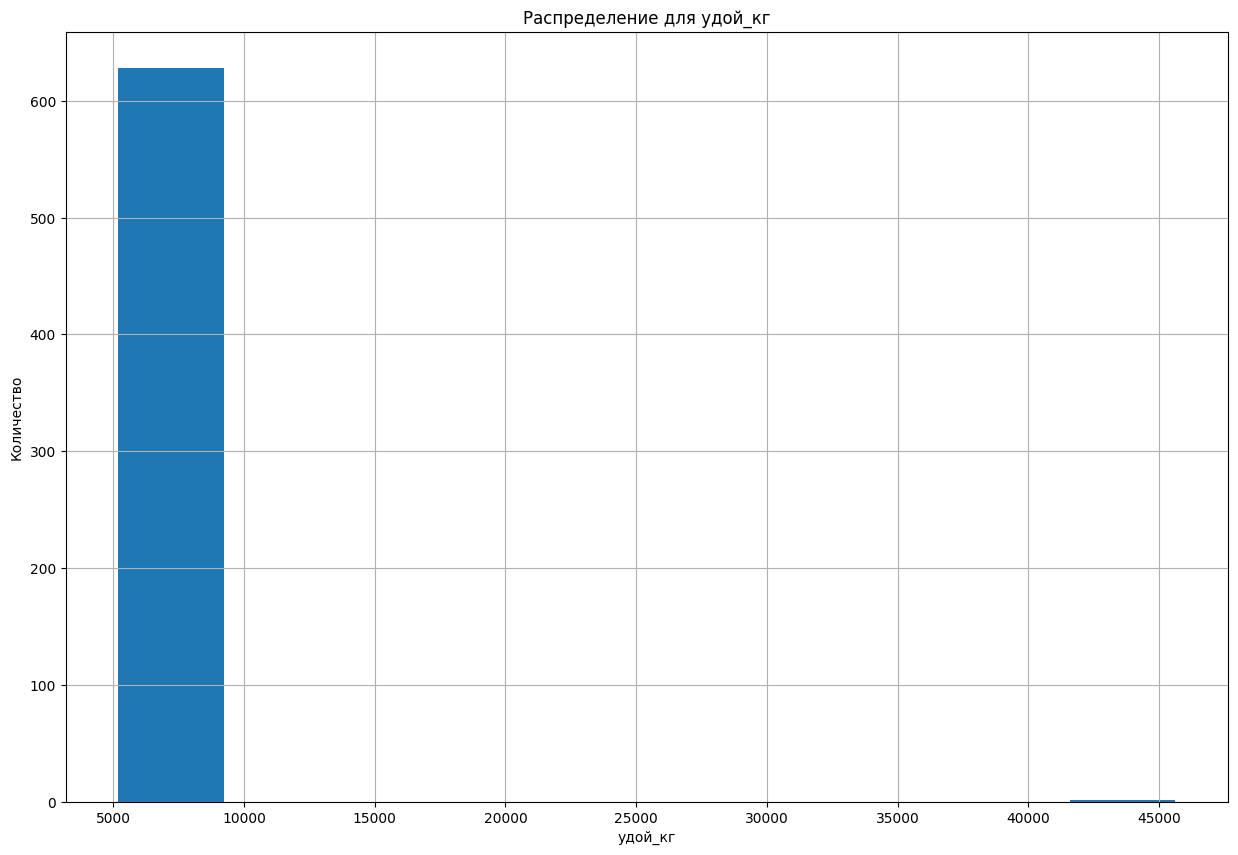

In [15]:
plot_n_describe(ferma['удой_кг'], 'hist')

In [16]:
ferma_bad = ferma[ferma['удой_кг'] > 10000]
ferma_bad 

id  удой_кг   эке  протеин_г   спо          порода   пастбище порода_папы  \
16  17    45616  11.5       1675  0.93  Вис Бик Айдиал  Холмистое     Айдиалл   

    жирность_%  белок_%  вкус  возраст_2+ имя_папы  
16        3.22    3.076  True        True   Буйный

Аномальное значение. Лучше удалить - едва ли одна корова даёт на порядок больше молока, чем остальные 

In [17]:
ferma.drop(ferma_bad.index, inplace=True)

count     628.000000
mean     6125.968153
std       475.857053
min      5204.000000
25%      5749.750000
50%      6132.500000
75%      6501.000000
max      7222.000000
Name: удой_кг, dtype: float64

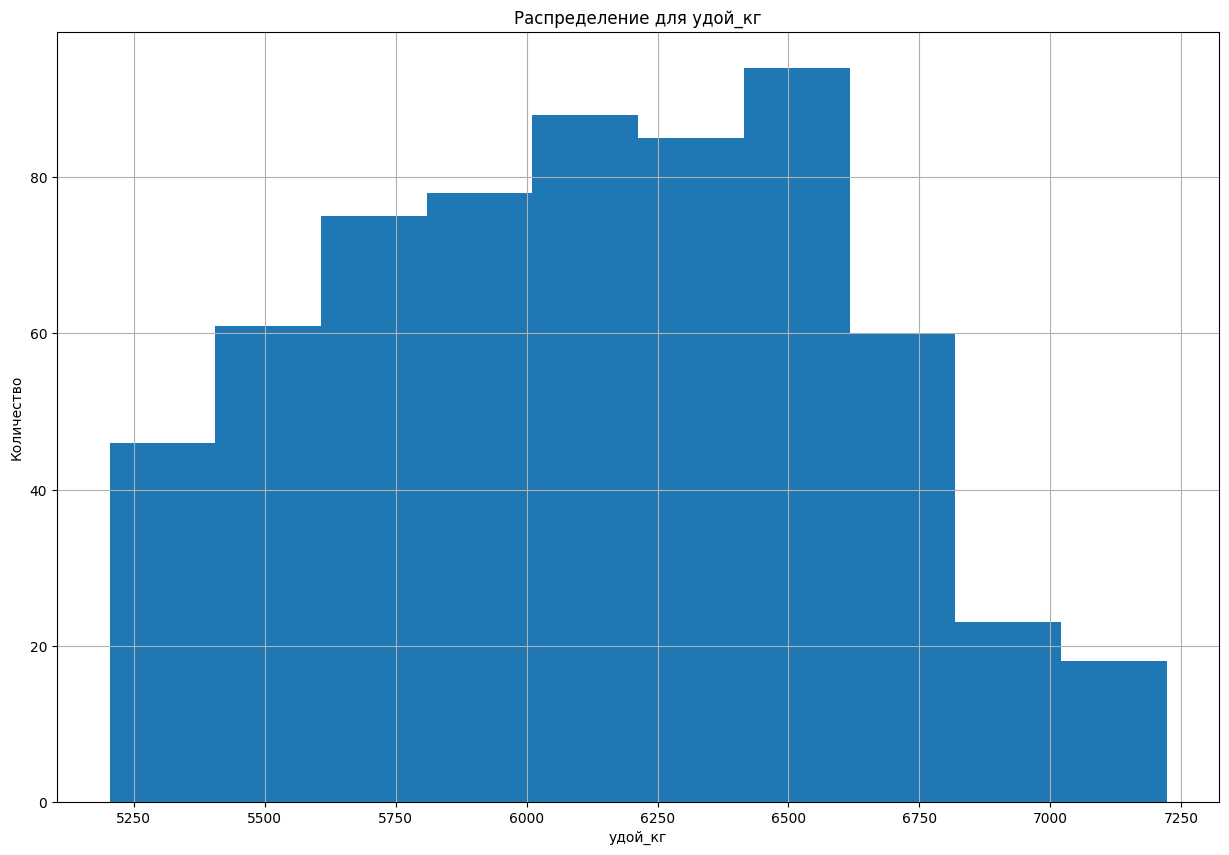

In [18]:
plot_n_describe(ferma['удой_кг'], 'hist')

Теперь порядок, распределение выглядит похожим на нормальное, хотя и не очень симметричное

### ЭКЕ

count    628.000000
mean      14.548726
std        1.301777
min       10.900000
25%       13.500000
50%       14.700000
75%       15.600000
max       16.800000
Name: эке, dtype: float64

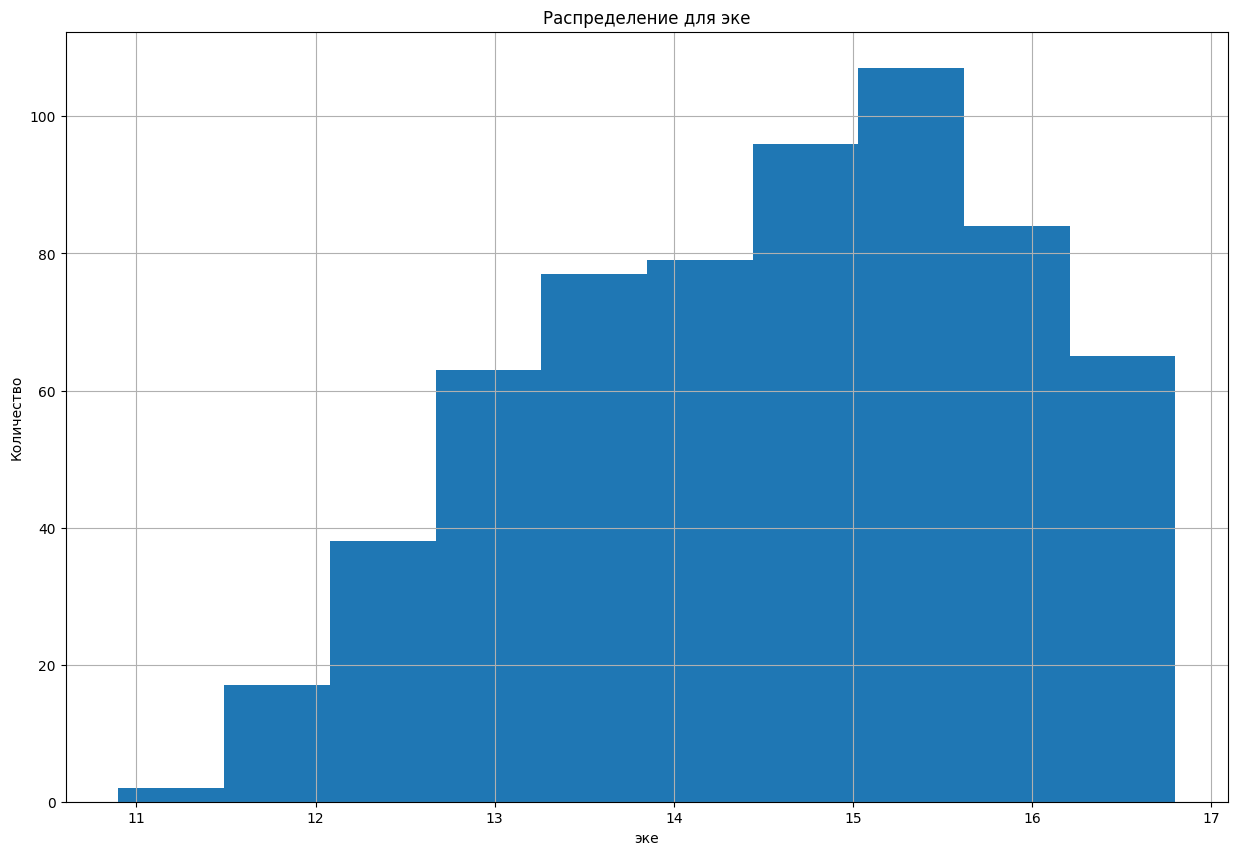

In [19]:
plot_n_describe(ferma['эке'], 'hist')

Распределение с небольшим перекосом вправо

### Протеин

count     628.000000
mean     1923.759554
std       182.832816
min      1660.000000
25%      1771.750000
50%      1888.000000
75%      2062.250000
max      2349.000000
Name: протеин_г, dtype: float64

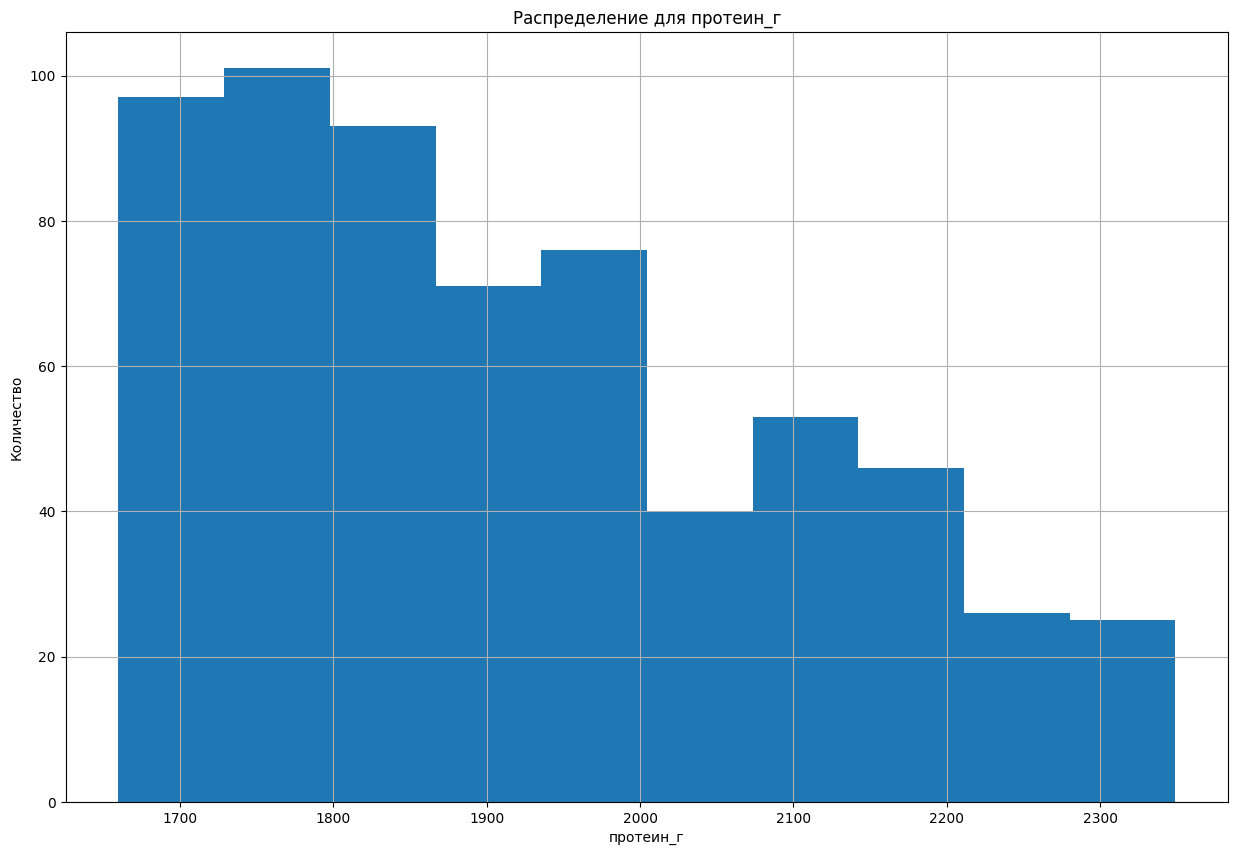

In [20]:
plot_n_describe(ferma['протеин_г'], 'hist')

Распределение смещено влево - видимо, у фермера есть причина лишь некоторым коровам давать корм с увеличенным количеством белка

### СПО

count    628.000000
mean       0.913089
std        0.032221
min        0.840000
25%        0.890000
50%        0.930000
75%        0.940000
max        0.960000
Name: спо, dtype: float64

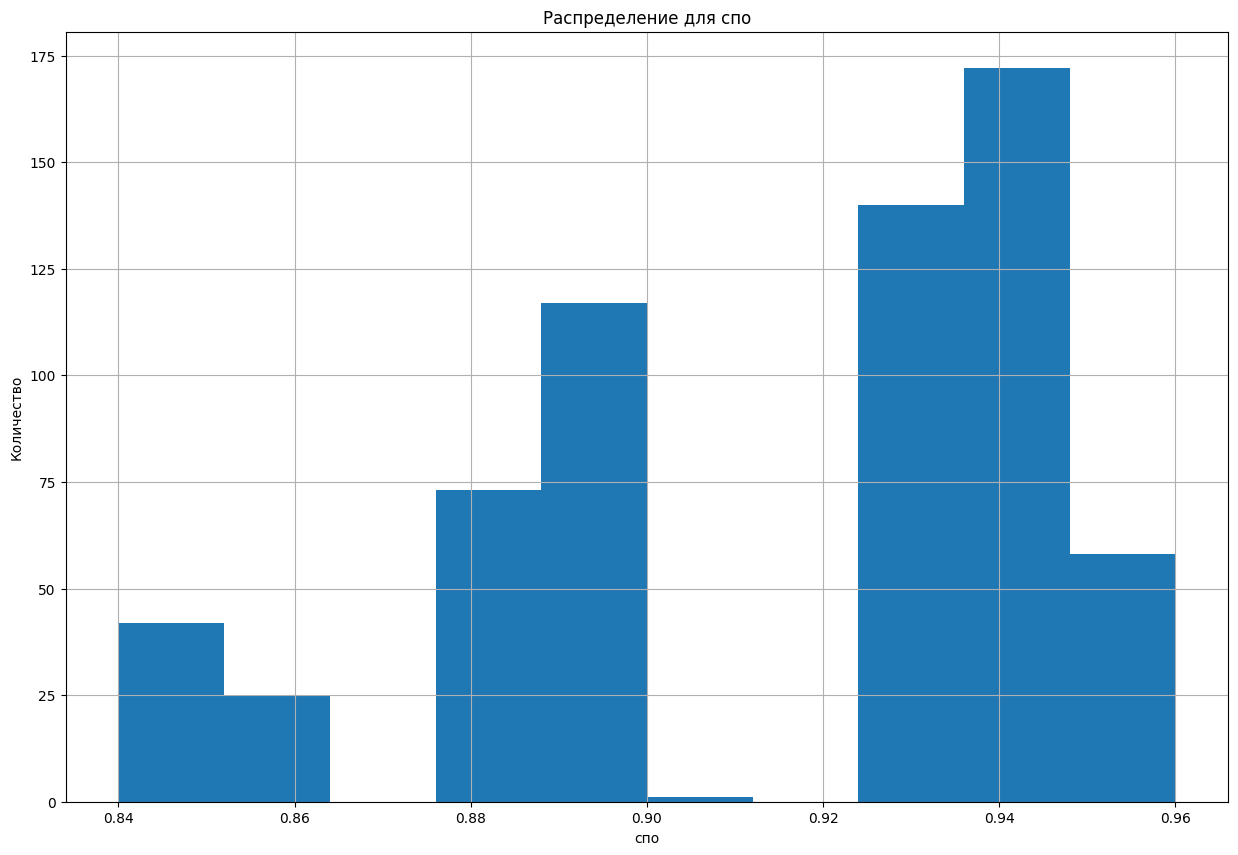

In [21]:
plot_n_describe(ferma['спо'], 'hist')

Видны три группы. Вероятно, есть стандартные соотношения углеводы/белки в корме

### Порода

count                628
unique                 2
top       Вис Бик Айдиал
freq                 372
Name: порода, dtype: object

порода
Вис Бик Айдиал     59.2
РефлешнСоверинг    40.8
Name: count, dtype: float64

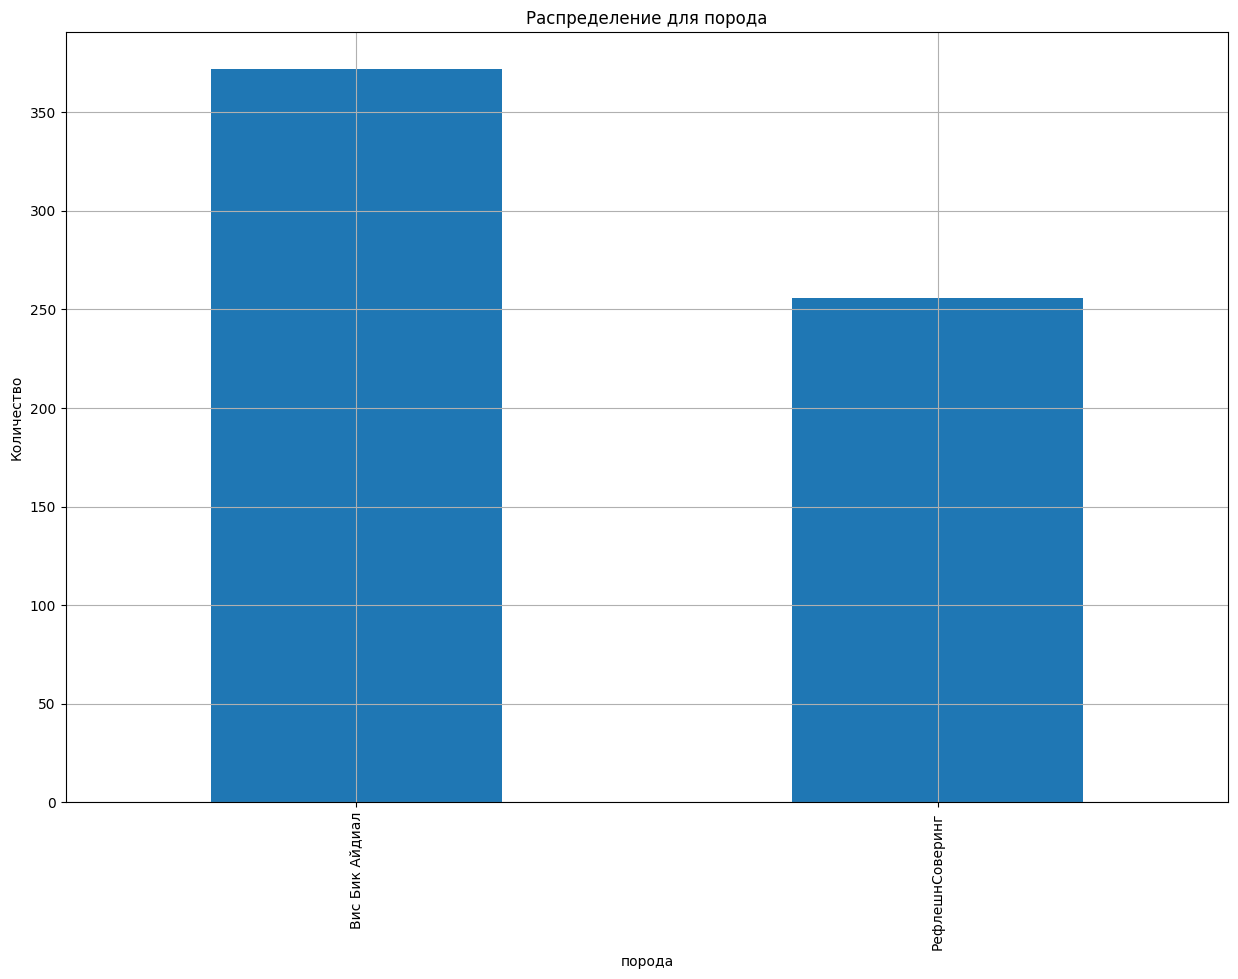

In [22]:
plot_n_describe(ferma['порода'], 'bar')

Две породы, 60 к 40

### Пастбище

count           628
unique            3
top       Холмистое
freq            350
Name: пастбище, dtype: object

пастбище
Холмистое    55.7
Равнинное    40.3
Равнинные     4.0
Name: count, dtype: float64

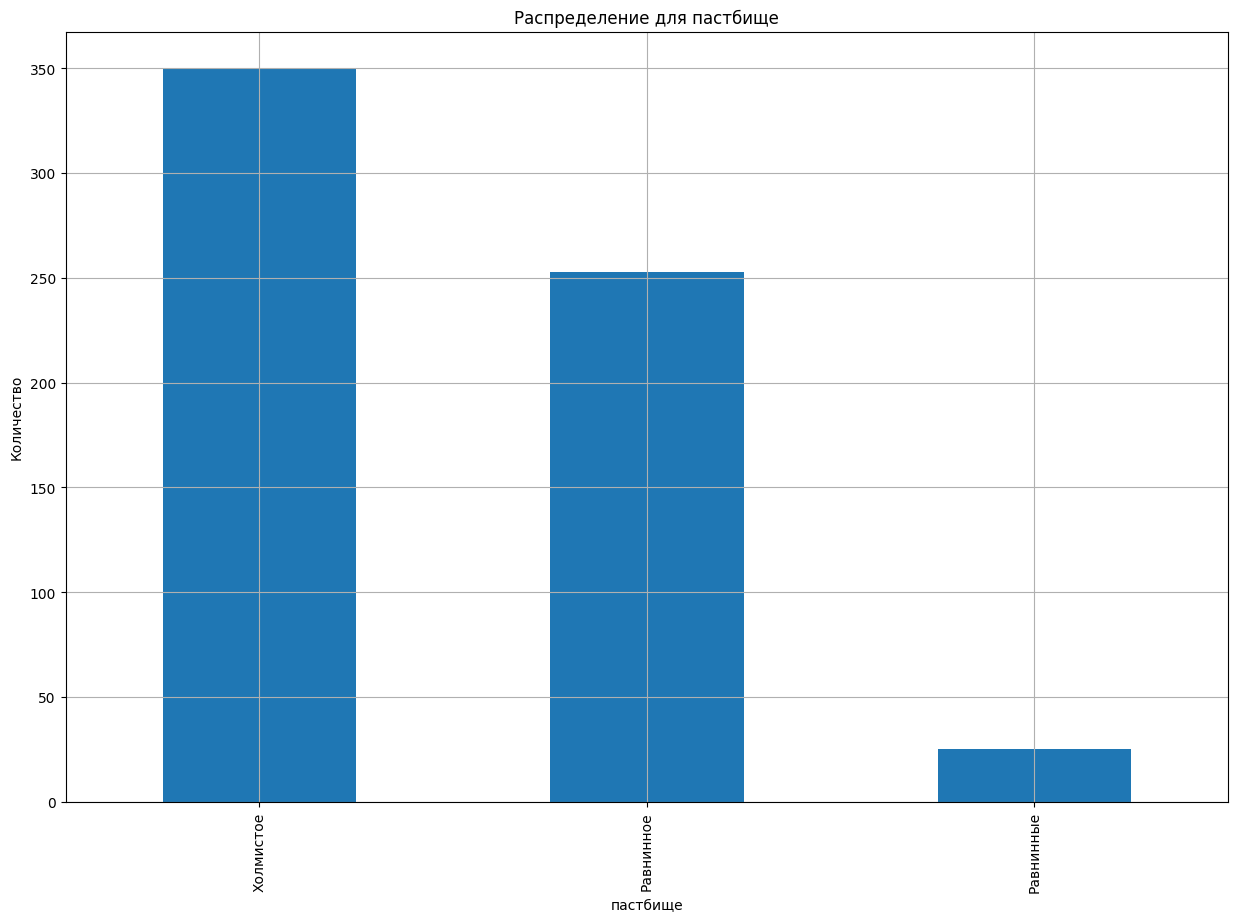

In [23]:
plot_n_describe(ferma['пастбище'], 'bar')

Явное дублирование "Равнинное" и "Равнинные". Надо исправить.

In [24]:
ferma['пастбище'] = ferma['пастбище'].replace('Равнинные', 'Равнинное')

Проверим, не было ли из-за этого неявных дубликатов

In [25]:
ferma.duplicated().sum()

0

count           628
unique            2
top       Холмистое
freq            350
Name: пастбище, dtype: object

пастбище
Холмистое    55.7
Равнинное    44.3
Name: count, dtype: float64

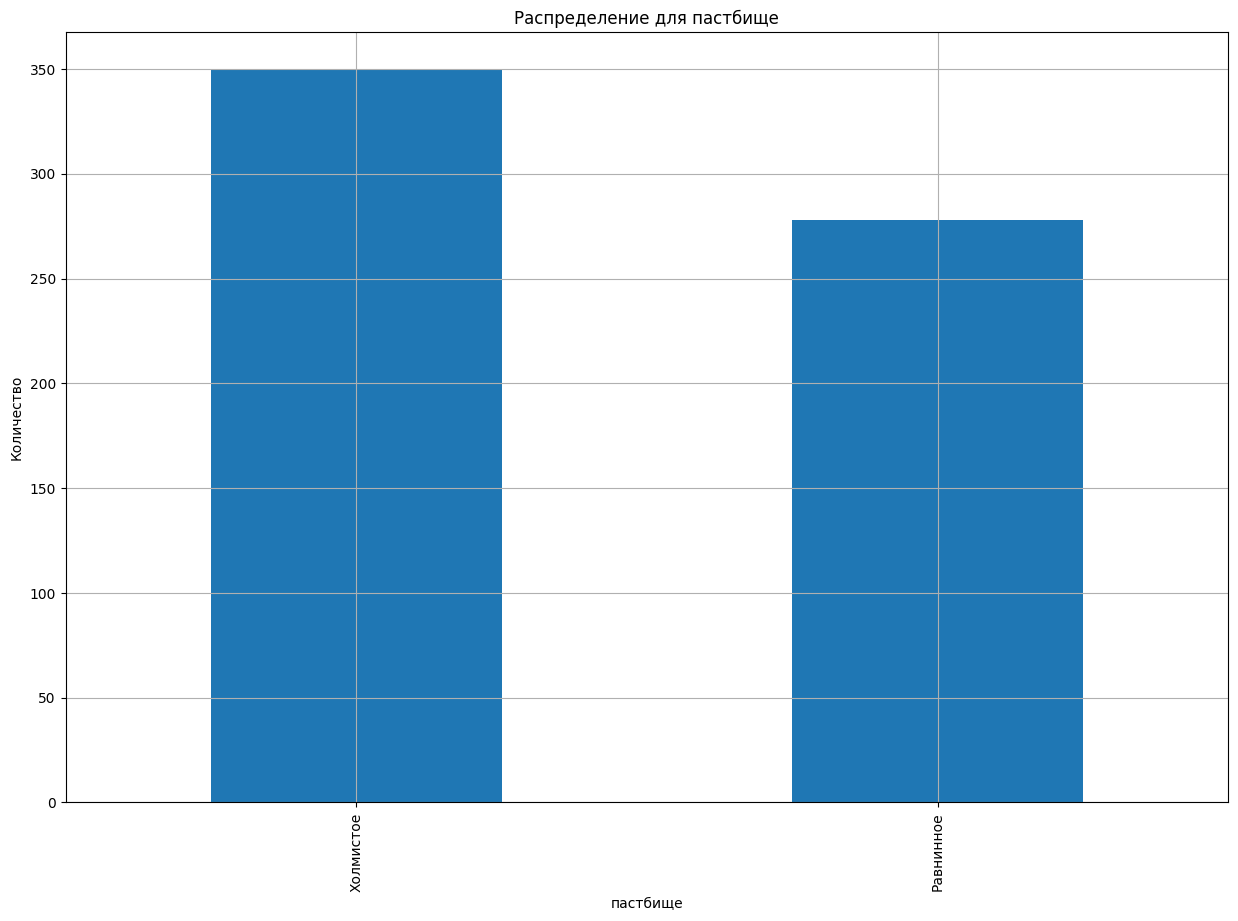

In [26]:
plot_n_describe(ferma['пастбище'], 'bar')

Два типа пастбищ, 55 к 45.

### Порода папы

count         628
unique          3
top       Соверин
freq          311
Name: порода_папы, dtype: object

порода_папы
Соверин    49.5
Айдиал     38.2
Айдиалл    12.3
Name: count, dtype: float64

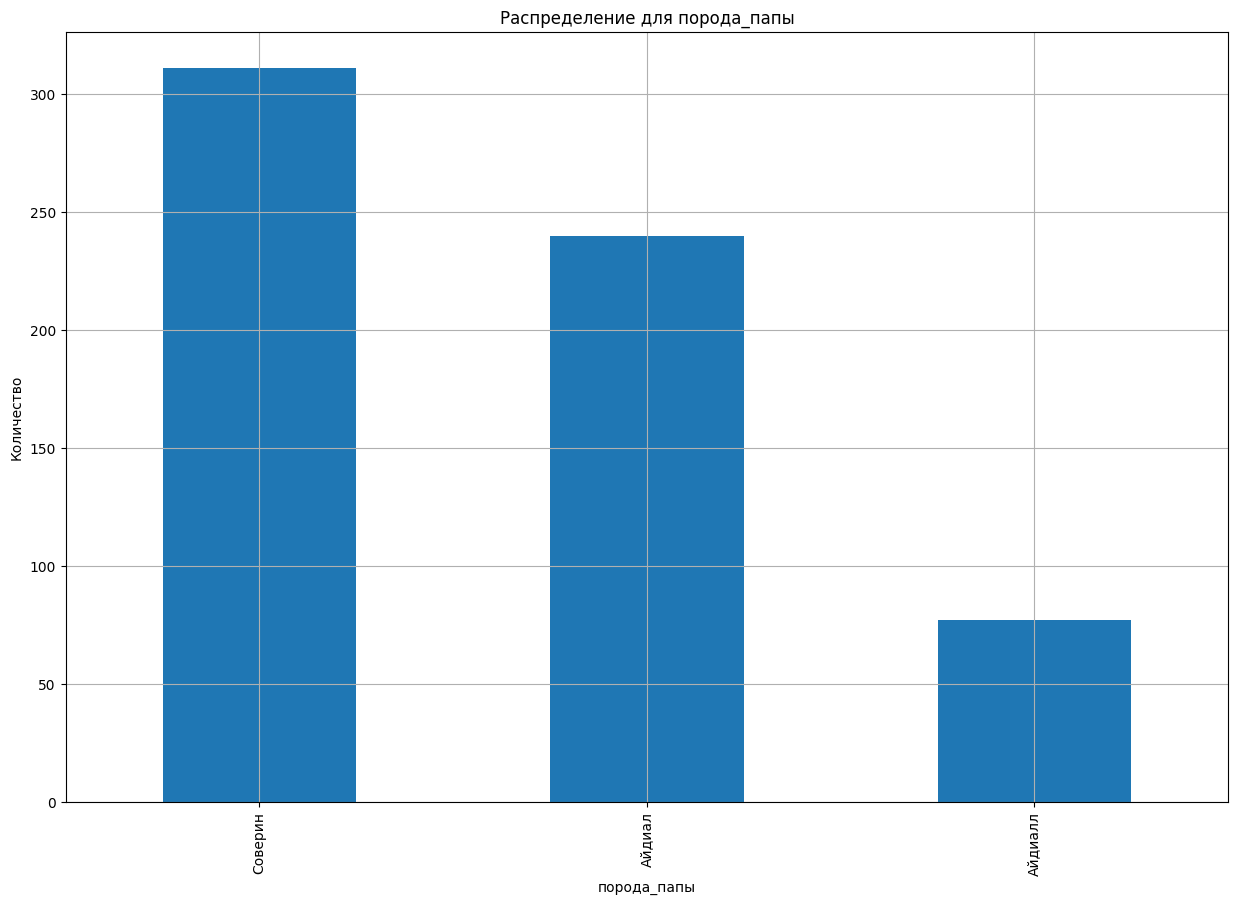

In [27]:
plot_n_describe(ferma['порода_папы'], 'bar')

Надо объединить "Айдиал" и "Айдиалл"

In [28]:
ferma['порода_папы'] = ferma['порода_папы'].replace('Айдиалл', 'Айдиал')

Проверим, не было ли из-за этого неявных дубликатов

In [29]:
ferma.duplicated().sum()

0

count        628
unique         2
top       Айдиал
freq         317
Name: порода_папы, dtype: object

порода_папы
Айдиал     50.5
Соверин    49.5
Name: count, dtype: float64

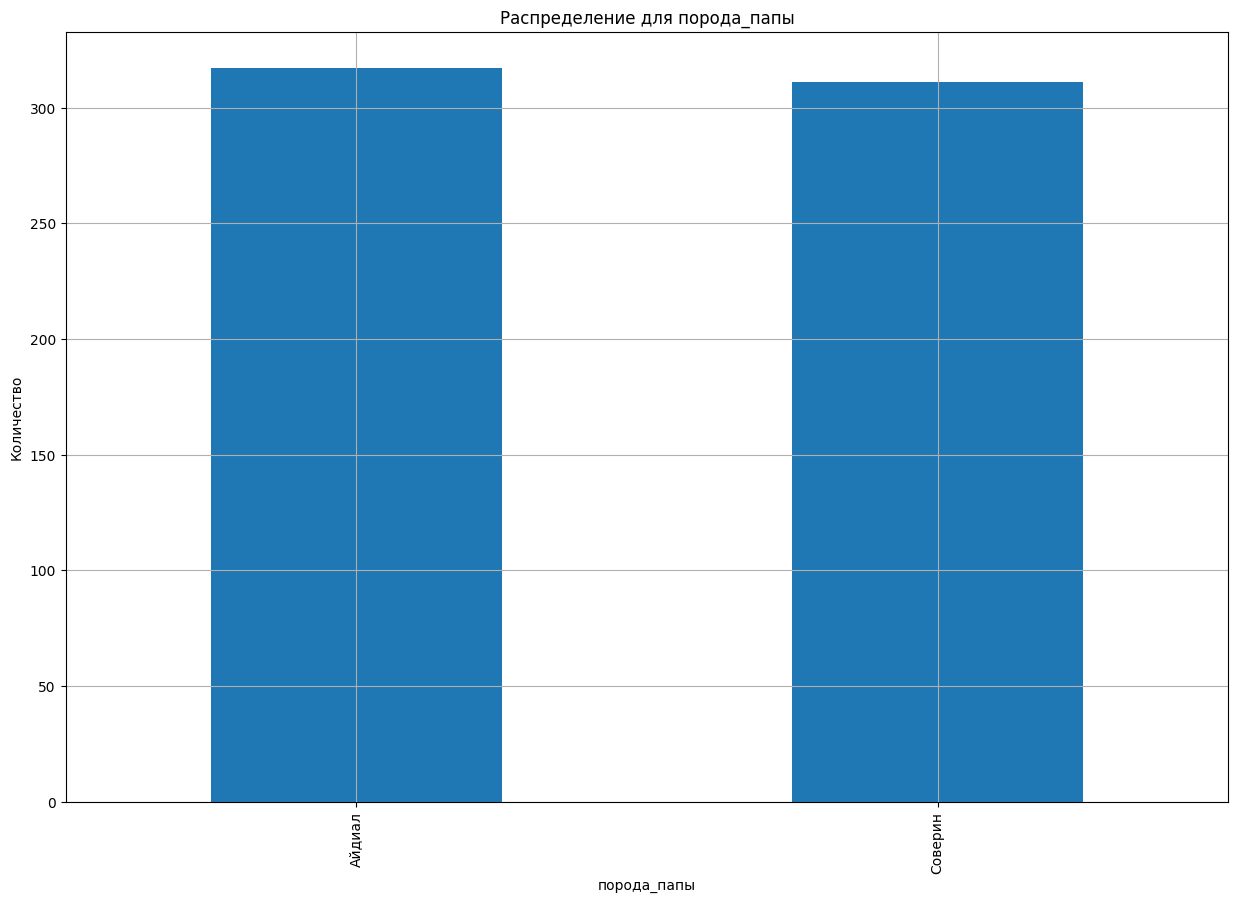

In [30]:
plot_n_describe(ferma['порода_папы'], 'bar')

Две породы пап, примерно 1 к 1

### Жирность

count    628.000000
mean       3.604268
std        0.168093
min        2.990000
25%        3.590000
50%        3.650000
75%        3.720000
max        3.750000
Name: жирность_%, dtype: float64

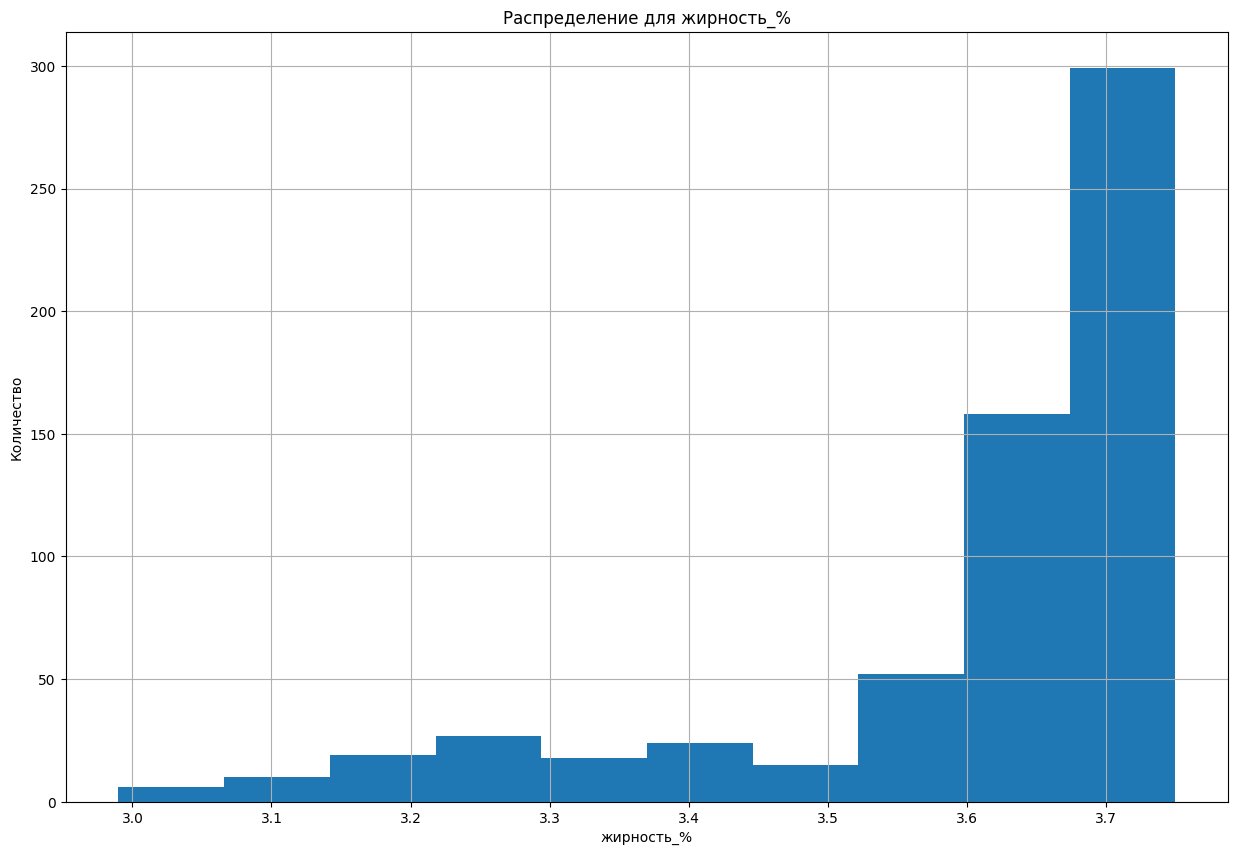

In [31]:
plot_n_describe(ferma['жирность_%'], 'hist')

Диапазон адекватный, но распределение сильно скощенное вправо. Вероятно, для таких пород, используемых кормов и т.д. так и должно быть. В такой ситуации, наверно, следует уточнять у заказчика. 

### Содержание белка

count    628.000000
mean       3.075670
std        0.002551
min        3.069000
25%        3.074000
50%        3.076000
75%        3.077000
max        3.085000
Name: белок_%, dtype: float64

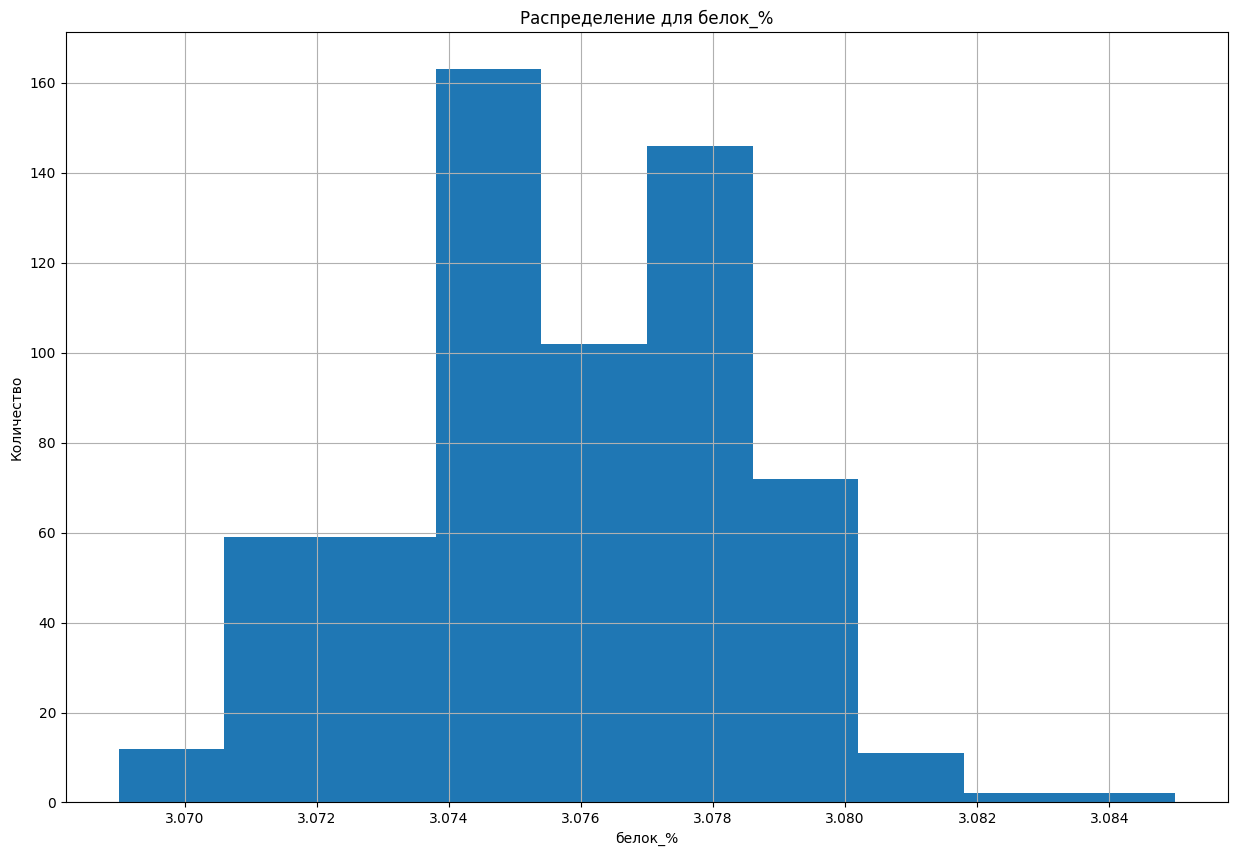

In [32]:
plot_n_describe(ferma['белок_%'], 'hist')

Для белка без аномалий, стоит только отметить очень маленькую дисперсию.

### Вкус

count      628
unique       2
top       True
freq       370
Name: вкус, dtype: object

вкус
True     58.9
False    41.1
Name: count, dtype: float64

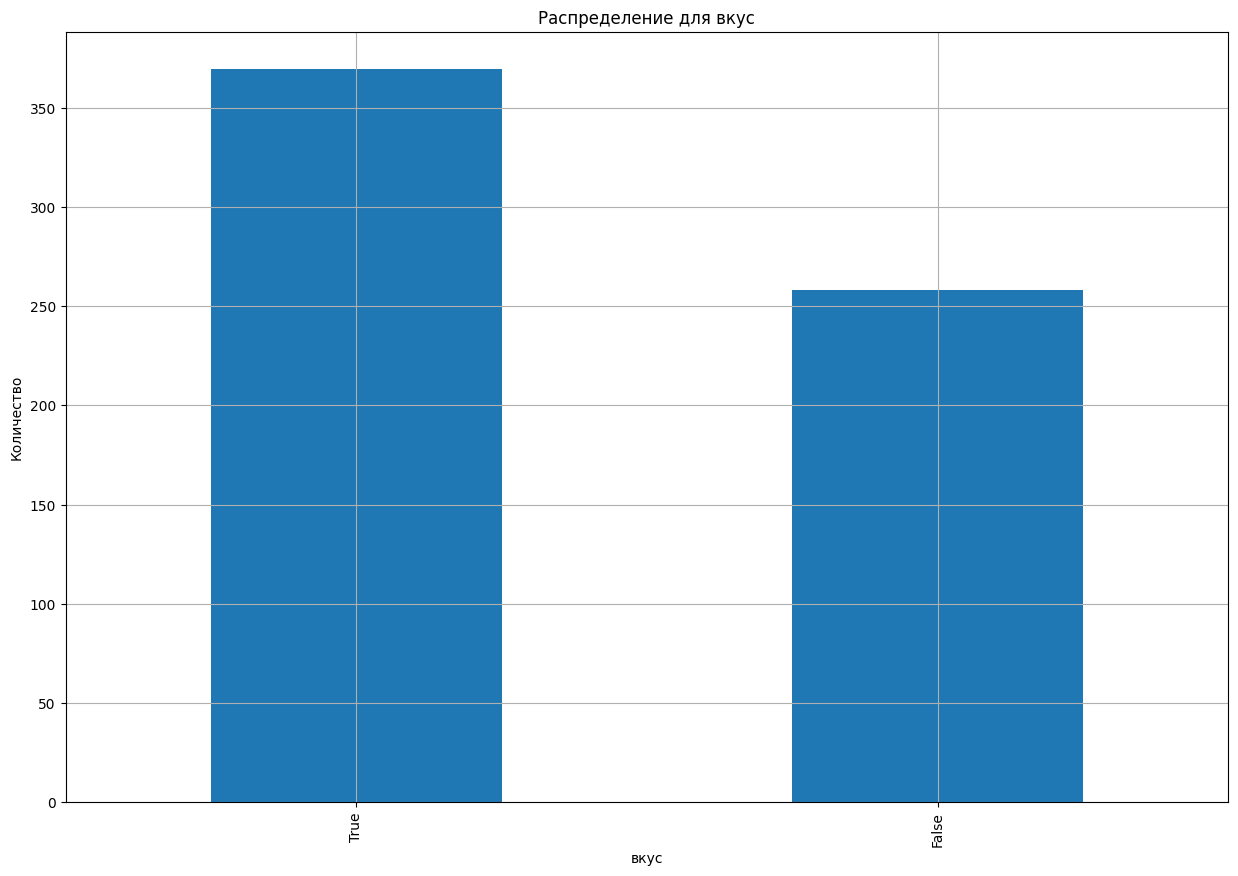

In [33]:
plot_n_describe(ferma['вкус'], 'bar')

Молоко 60% коров фермер считает вкусным

### Возраст

count      628
unique       2
top       True
freq       518
Name: возраст_2+, dtype: object

возраст_2+
True     82.5
False    17.5
Name: count, dtype: float64

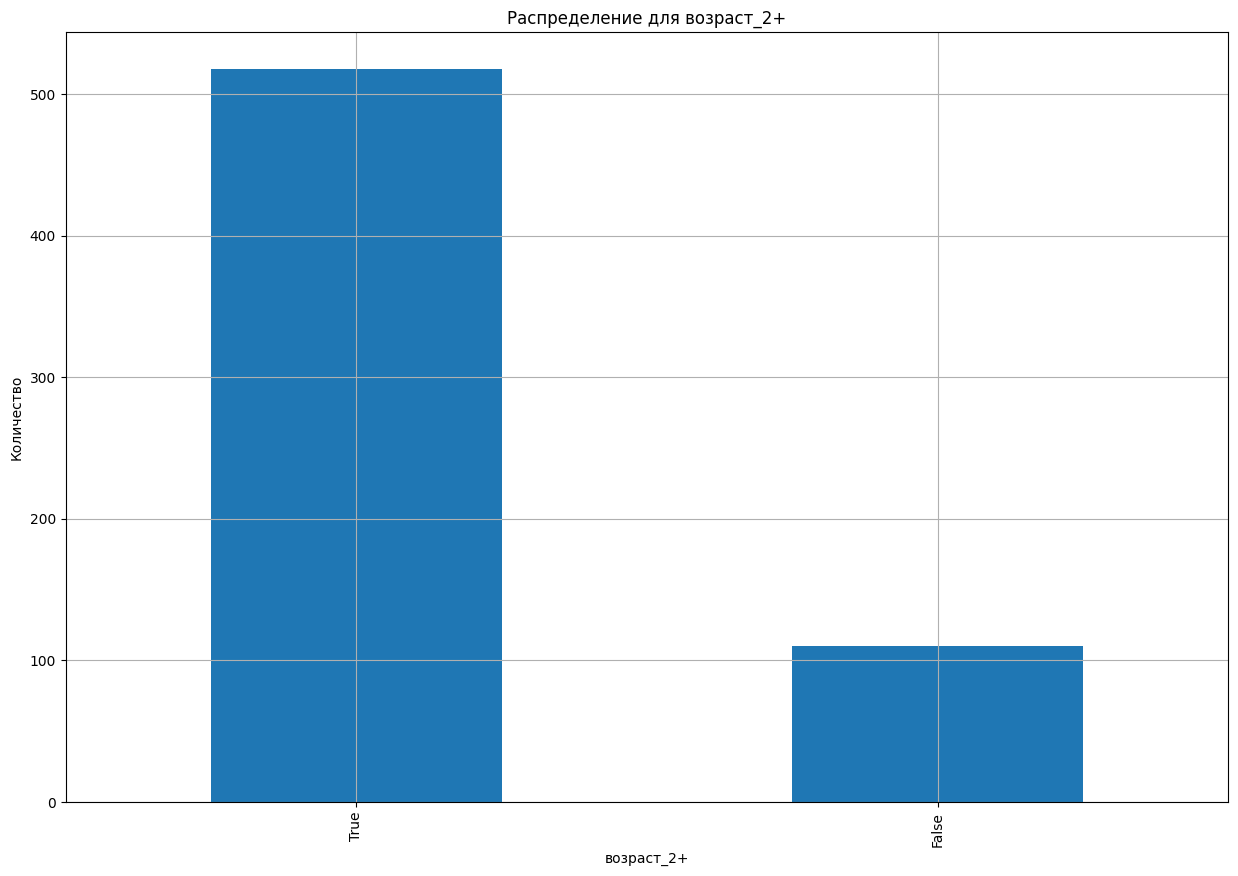

In [34]:
plot_n_describe(ferma['возраст_2+'], 'bar')

Больше 80% коров на ферме старше 2 лет. Адекватно - коровы живут 20-30 лет 

### Имя папы

count       628
unique        4
top       Барин
freq        240
Name: имя_папы, dtype: object

имя_папы
Барин       38.2
Буйный      34.1
Соловчик    17.5
Геркулес    10.2
Name: count, dtype: float64

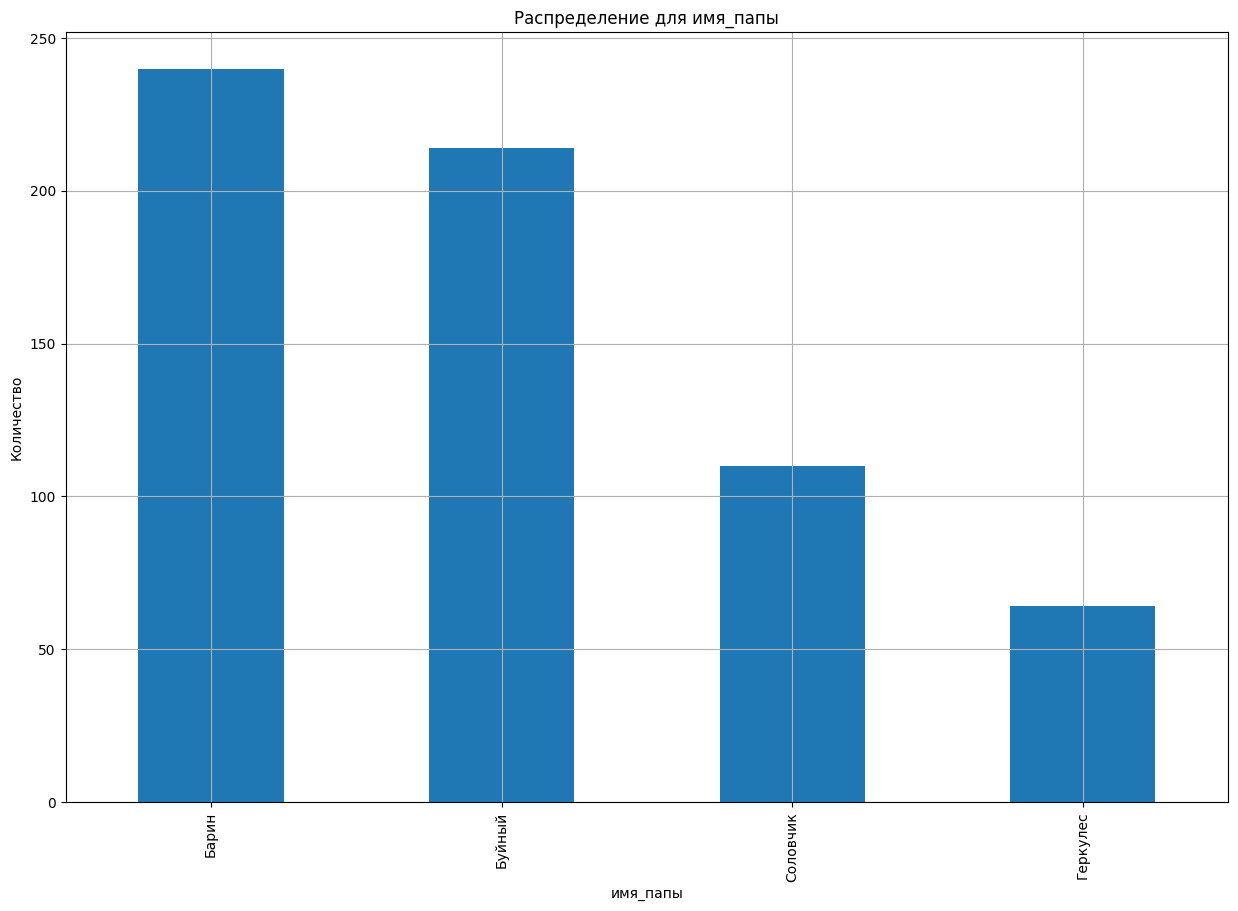

In [35]:
plot_n_describe(ferma['имя_папы'], 'bar')

4 быка, 2 встречаются чаще всего

### Сопоставление с cow_buy

count                  20
unique                  2
top       РефлешнСоверинг
freq                   11
Name: порода, dtype: object

порода
РефлешнСоверинг    55.0
Вис Бик Айдиал     45.0
Name: count, dtype: float64

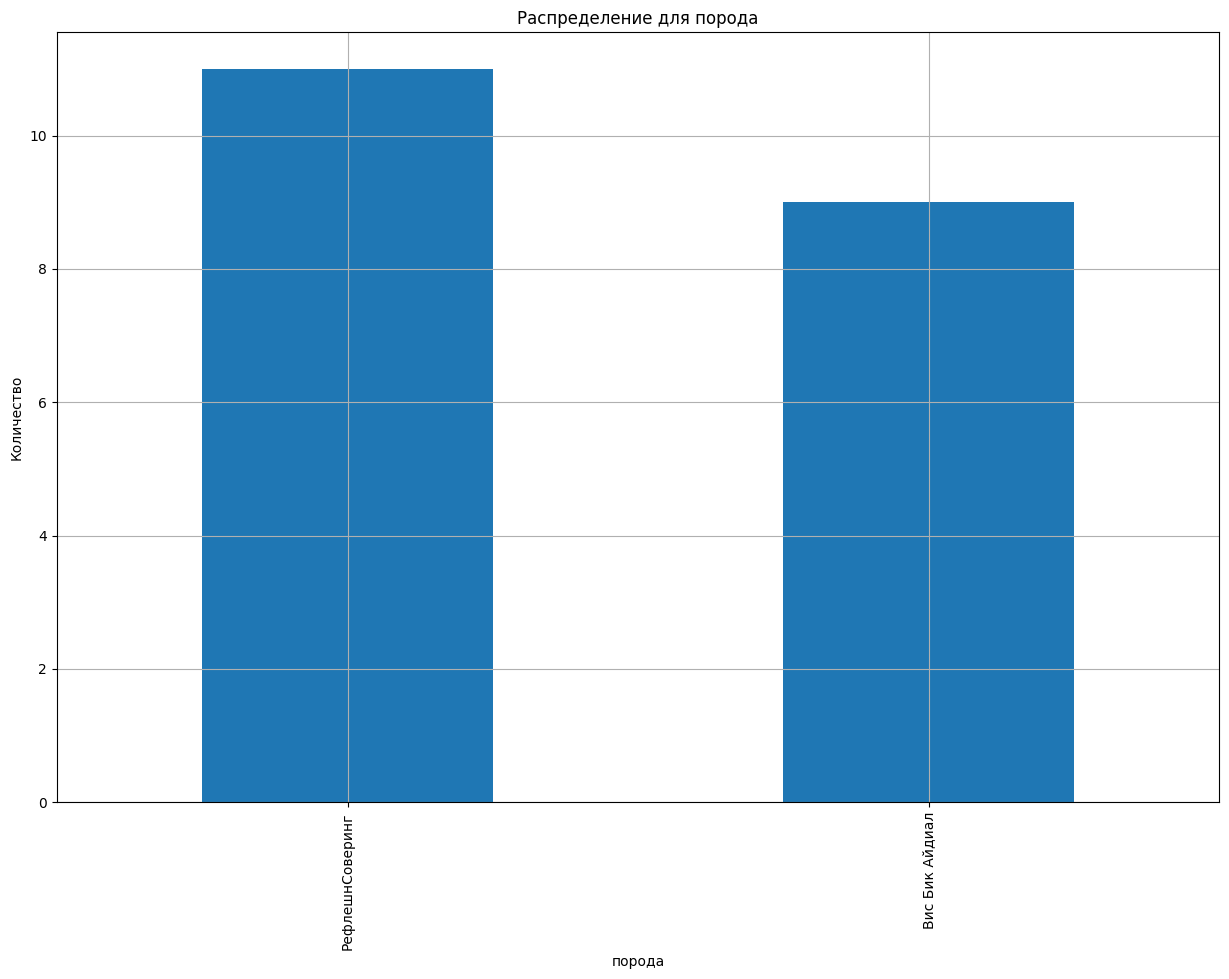

count            20
unique            2
top       равнинное
freq             11
Name: пастбище, dtype: object

пастбище
равнинное    55.0
холмистое    45.0
Name: count, dtype: float64

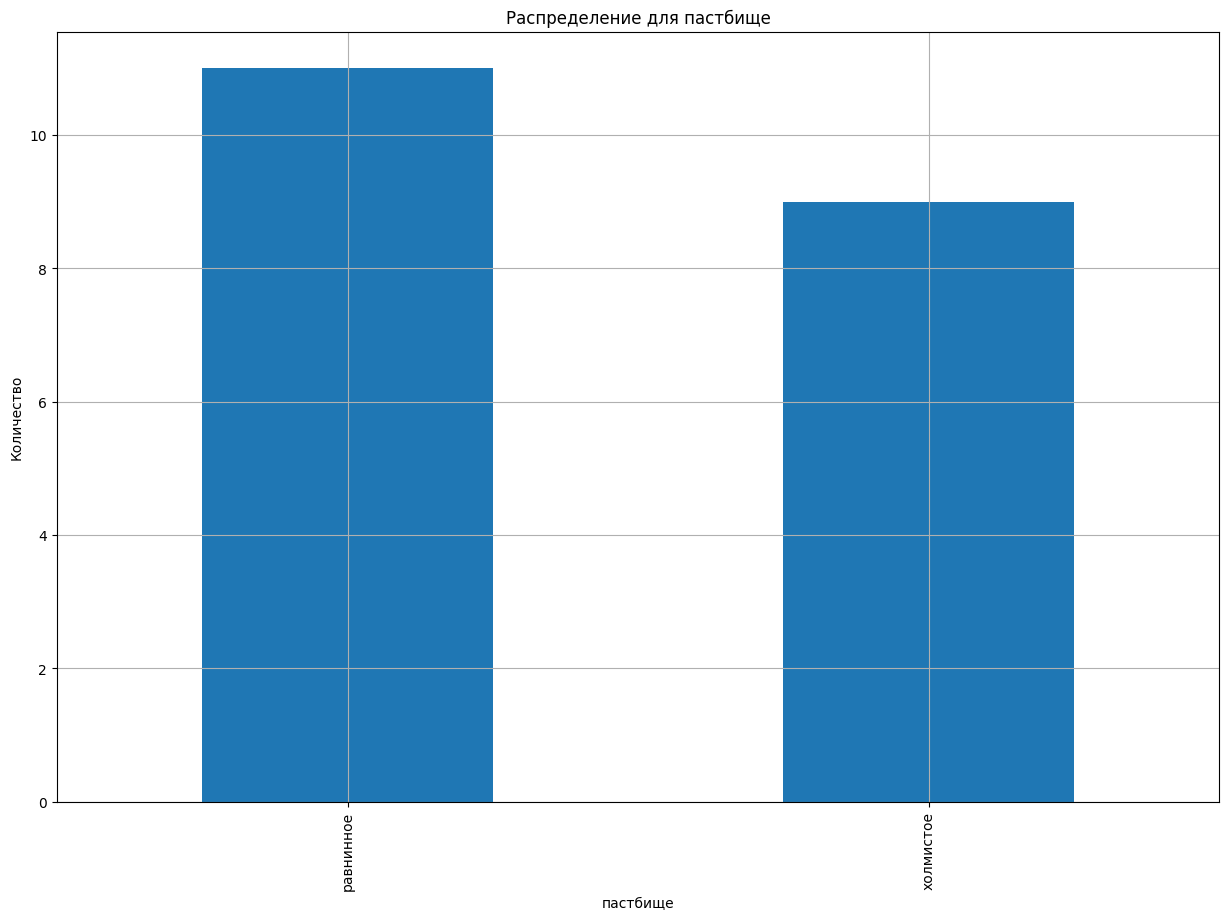

count          20
unique          2
top       Соверин
freq           12
Name: порода_папы, dtype: object

порода_папы
Соверин    60.0
Айдиал     40.0
Name: count, dtype: float64

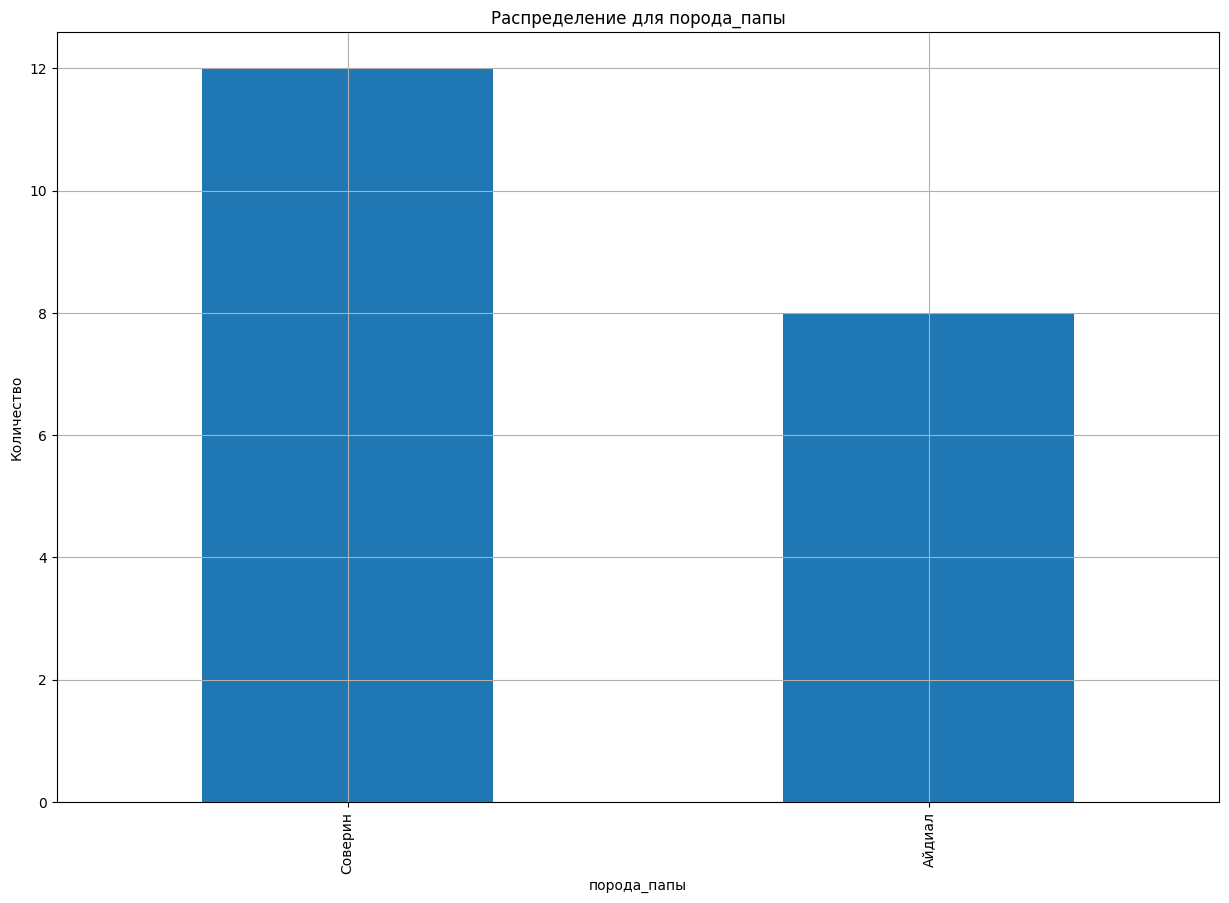

count         20
unique         4
top       Буйный
freq           8
Name: имя_папы, dtype: object

имя_папы
Буйный      40.0
Геркулес    30.0
Барин       20.0
Соловчик    10.0
Name: count, dtype: float64

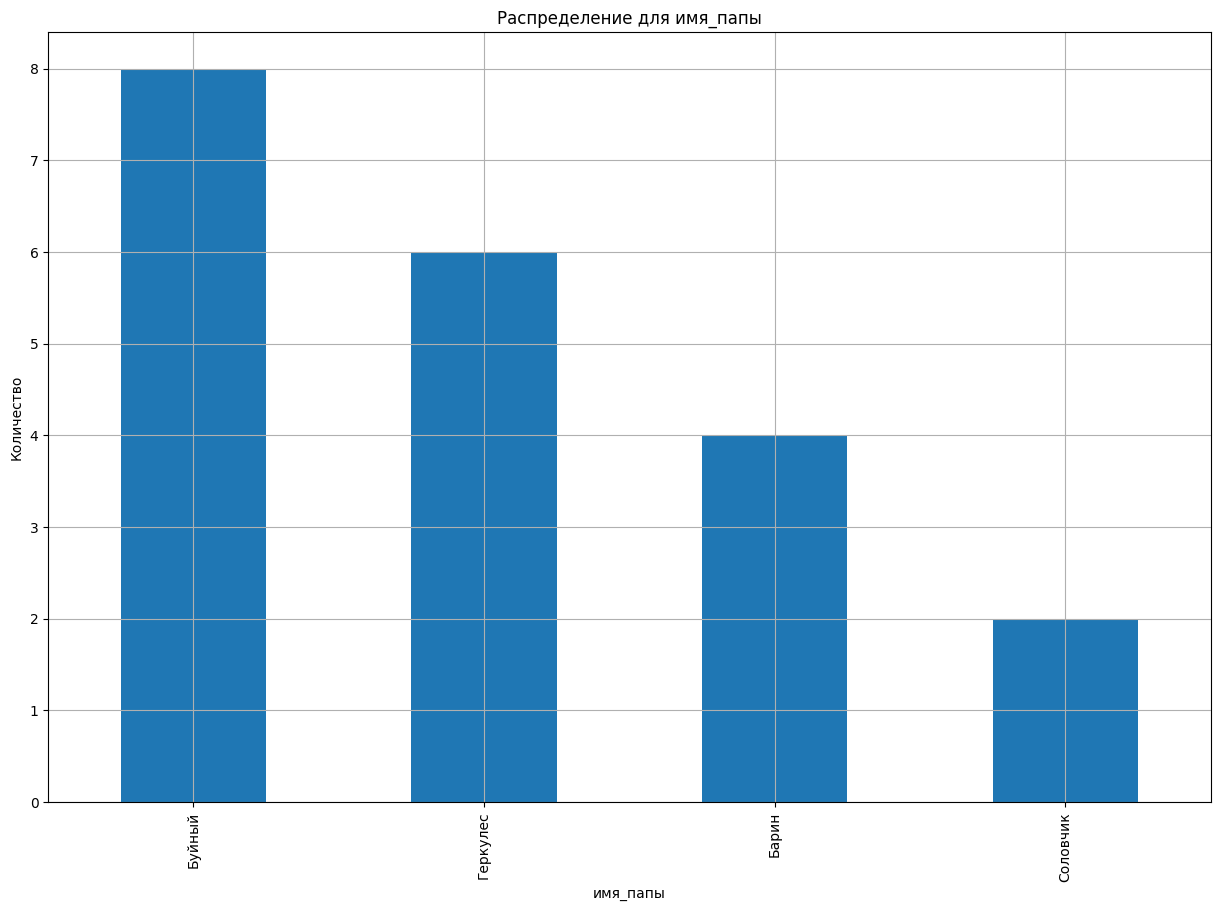

In [36]:
columns = ['порода', 'пастбище', 'порода_папы', 'имя_папы']

for col in columns:
    plot_n_describe(cow_buy[col], 'bar')

Регистр у пастбища надо поменять

In [37]:
cow_buy['пастбище'] = cow_buy['пастбище'].str.capitalize() 

После сделанных замен значения категориальных признаков из ferma и cow_buy согласуются 

### Итог

После исключения одной аномалии и коррекции значений для пород и пастбищ данные выглядят готовыми к анализу и использованию в МО

## Корреляционный анализ

### Коэффициенты корреляции

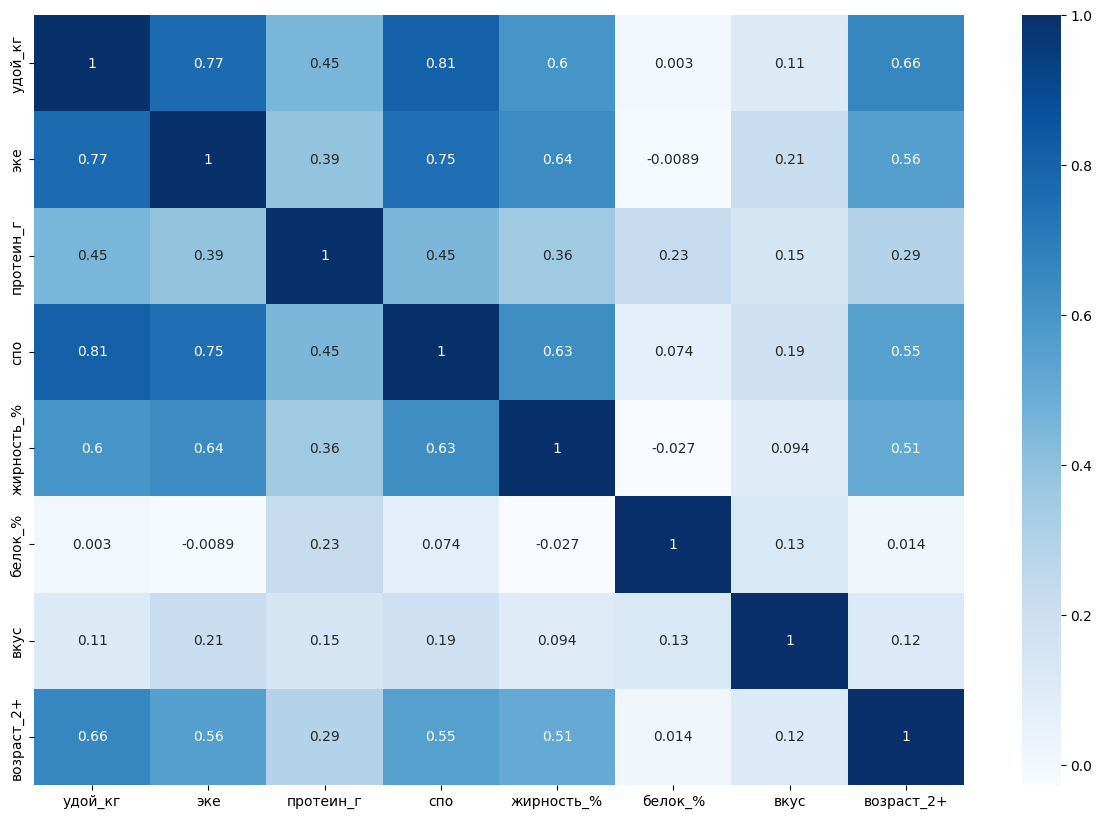

In [38]:
plt.figure(figsize = (15, 10))
sns.heatmap(
    ferma.drop('id', axis=1).select_dtypes(exclude=['object']).corr(),
    cmap="Blues",
    annot=True)
plt.show()

Удой положительно коррелирует с:
- ЭКЕ (высокая связь)
- протеином в корме (слабая)
- СПО (высокая)
- жирностью молока (средняя)
- возрастом (средняя) 

Два последних признака есть в cow_buy.
Важно, что возраст тут бинарный и вывод скорее "от коров младше 2 лет удои меньше"

Вкус с количественными признаками коррелирует слабо - вероятно, тут важнее категориальные.

### Диаграммы рассеяния


======================================== эке ========================================



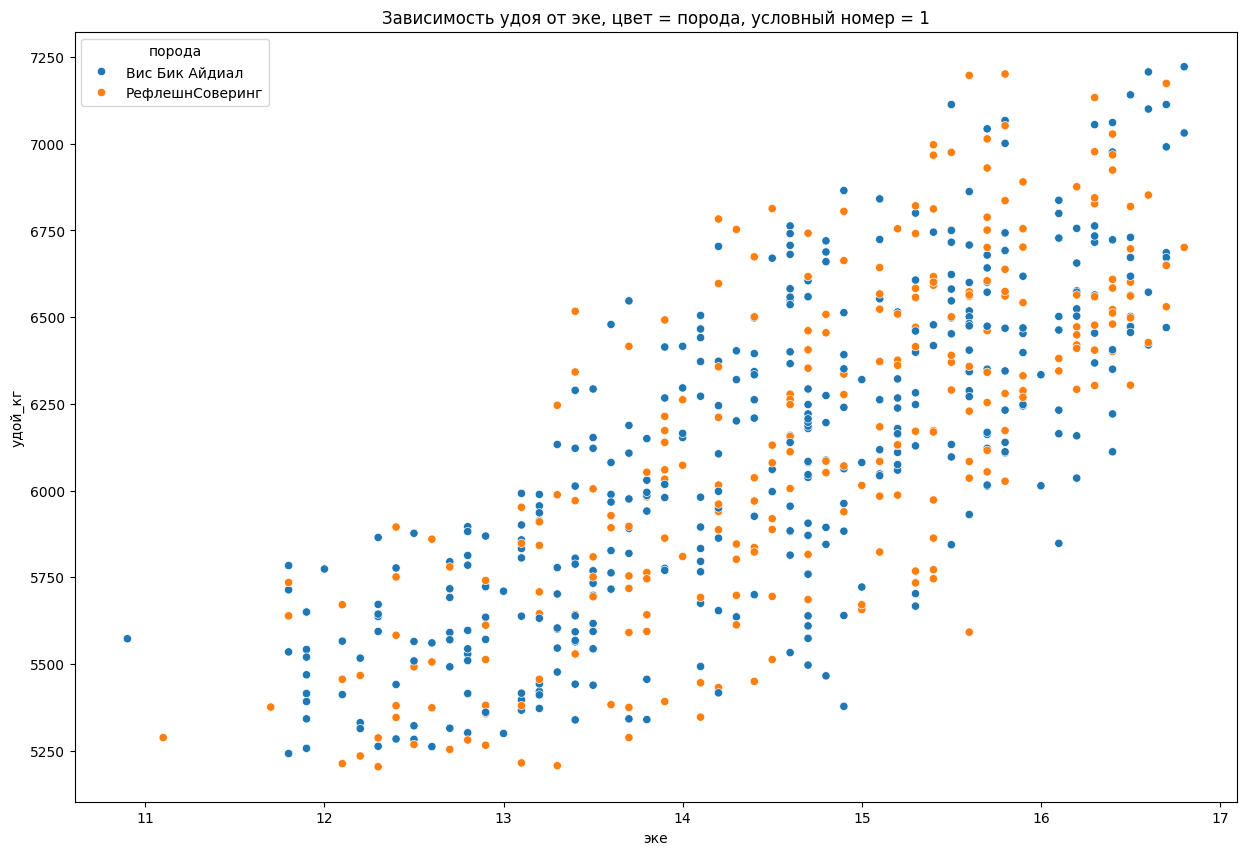

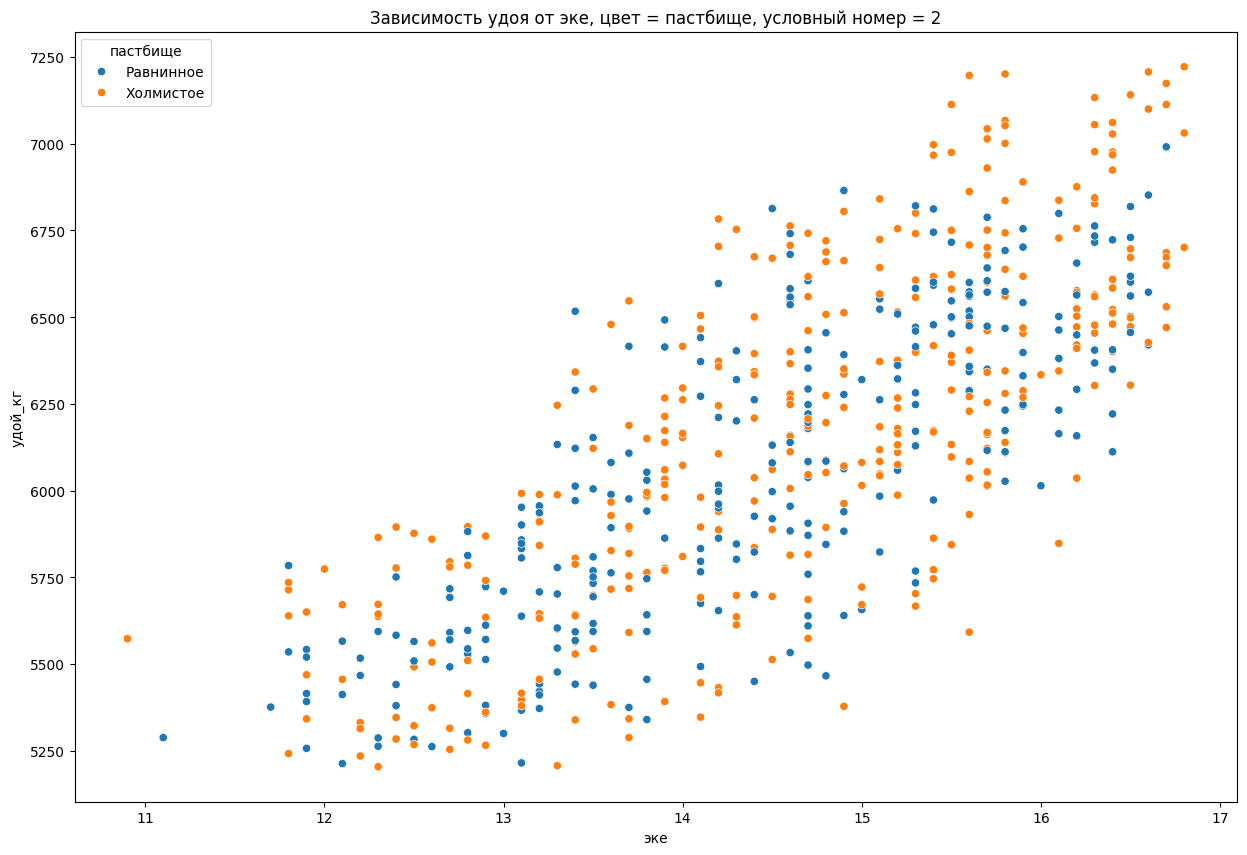

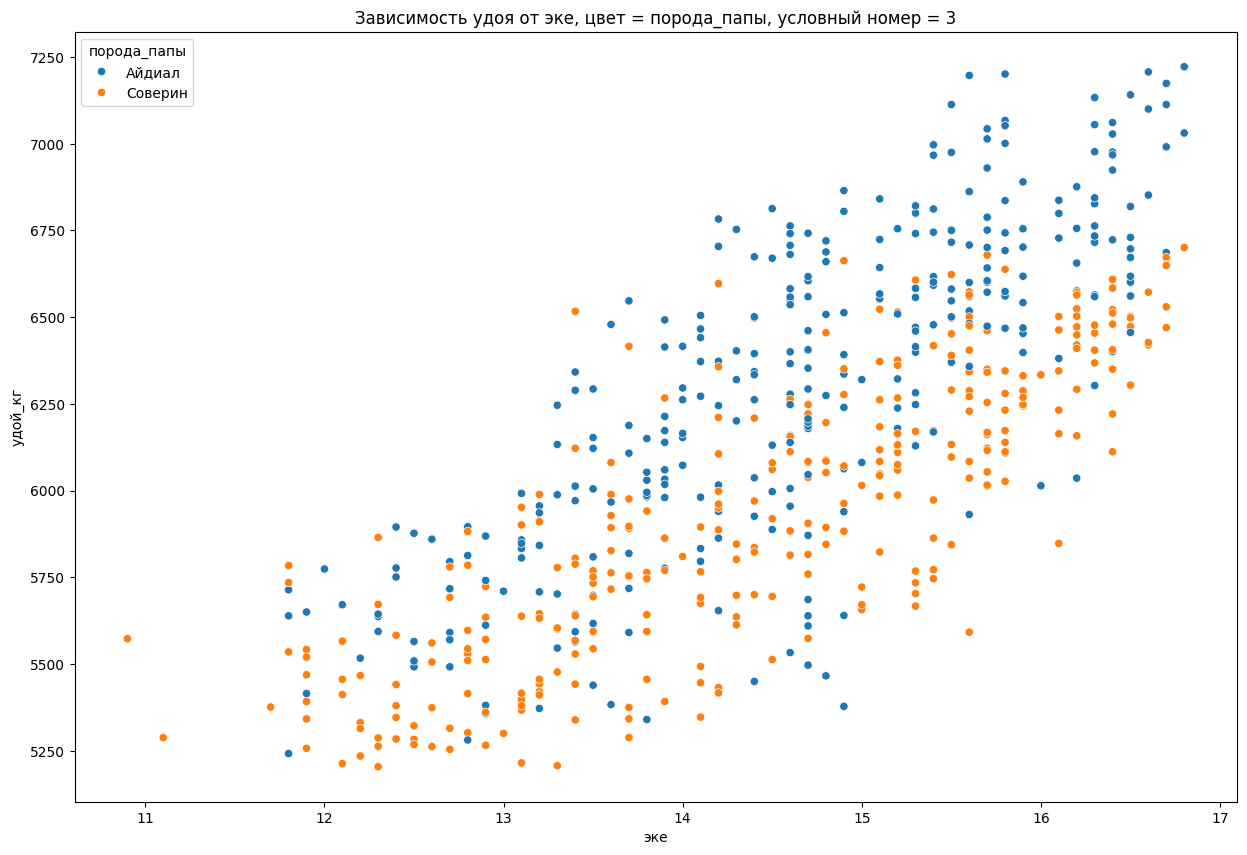

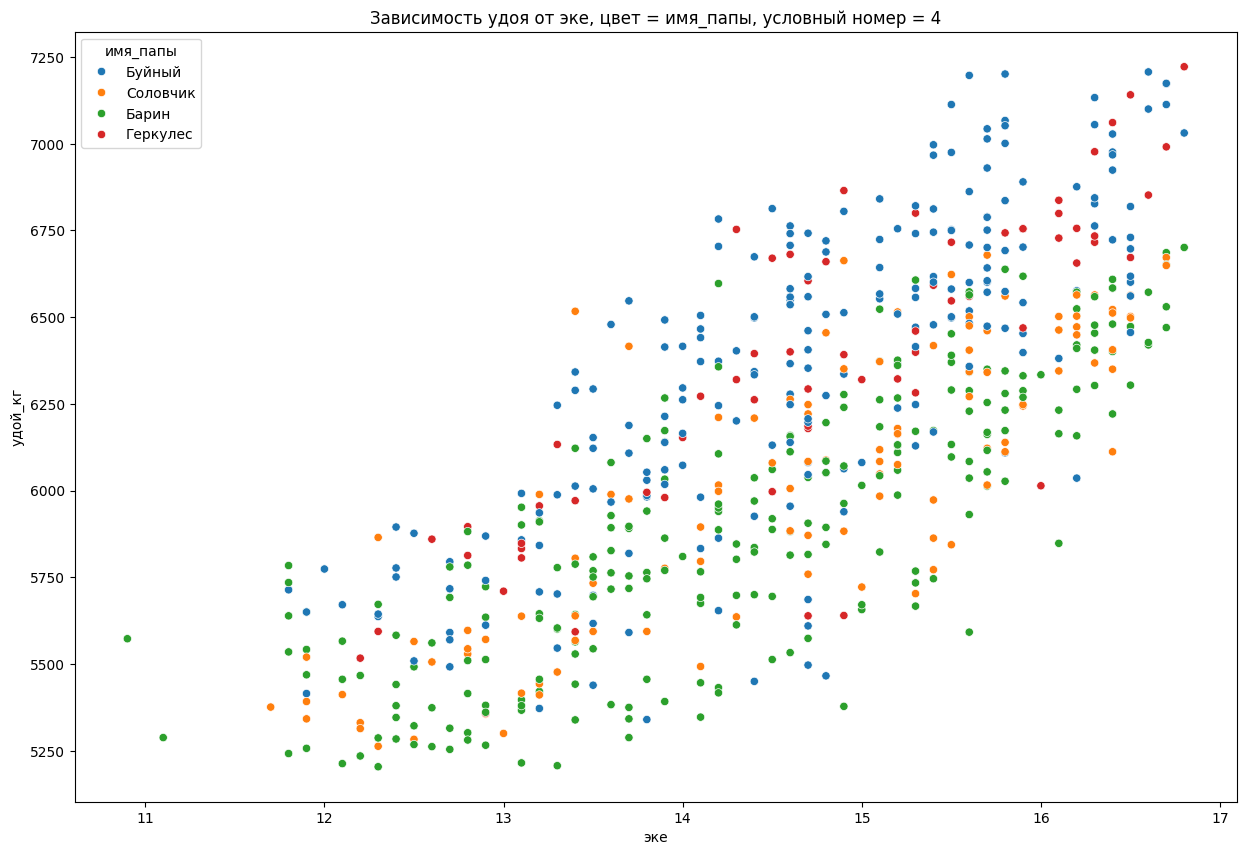


======================================== протеин_г ========================================



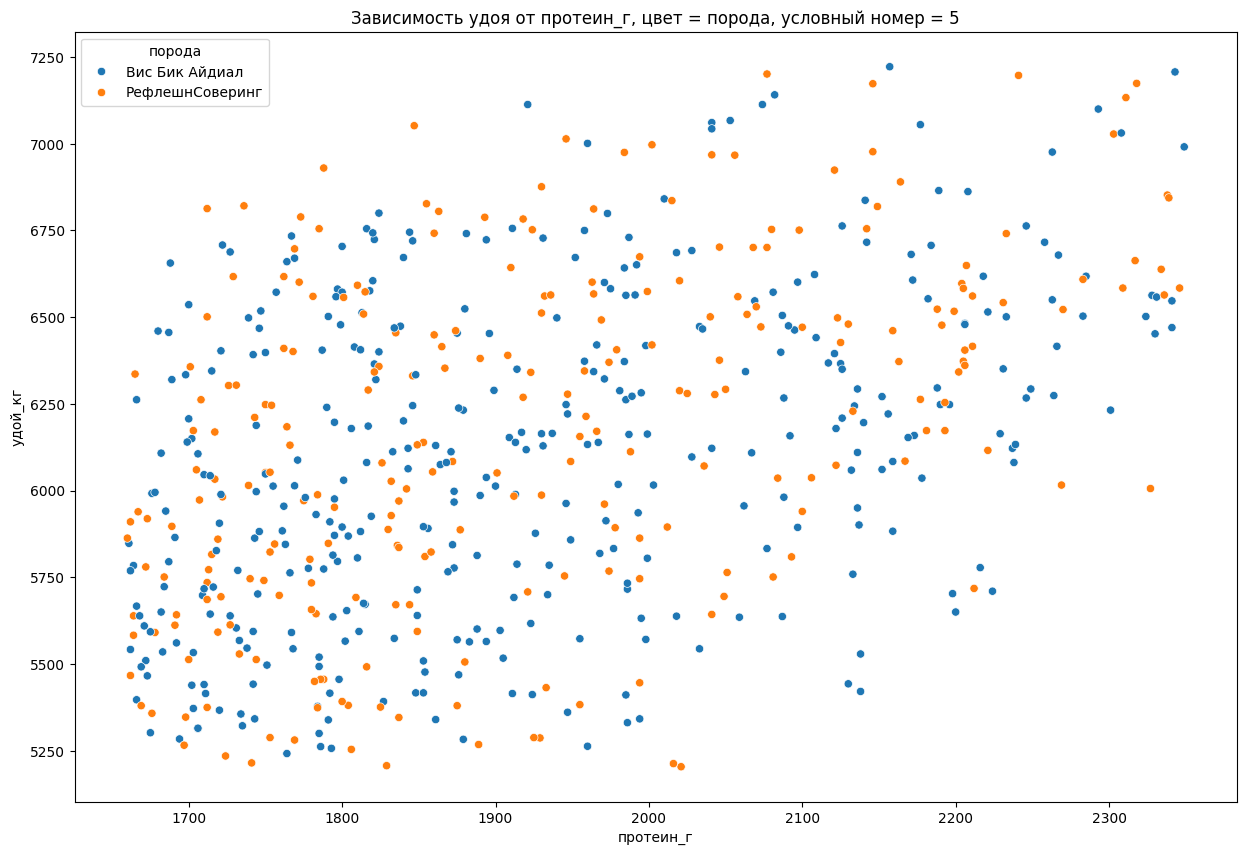

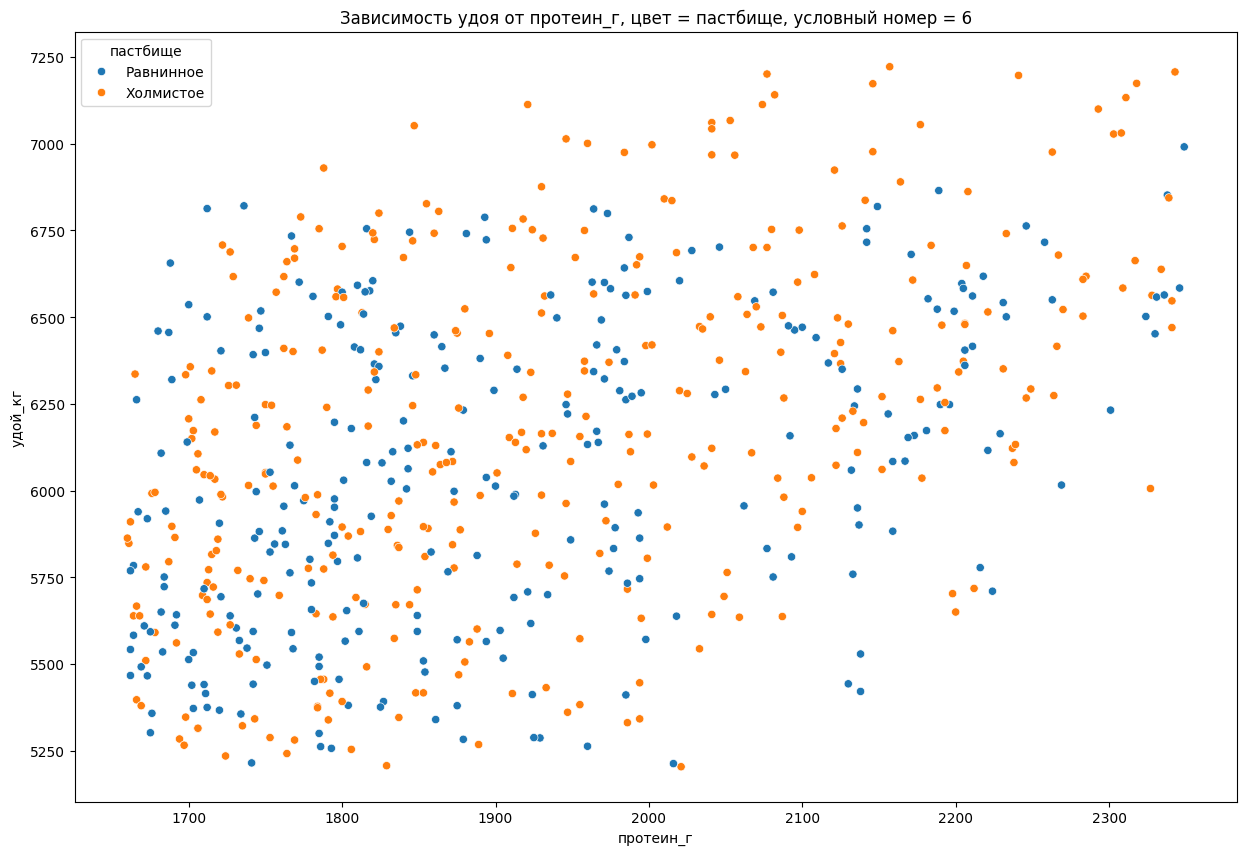

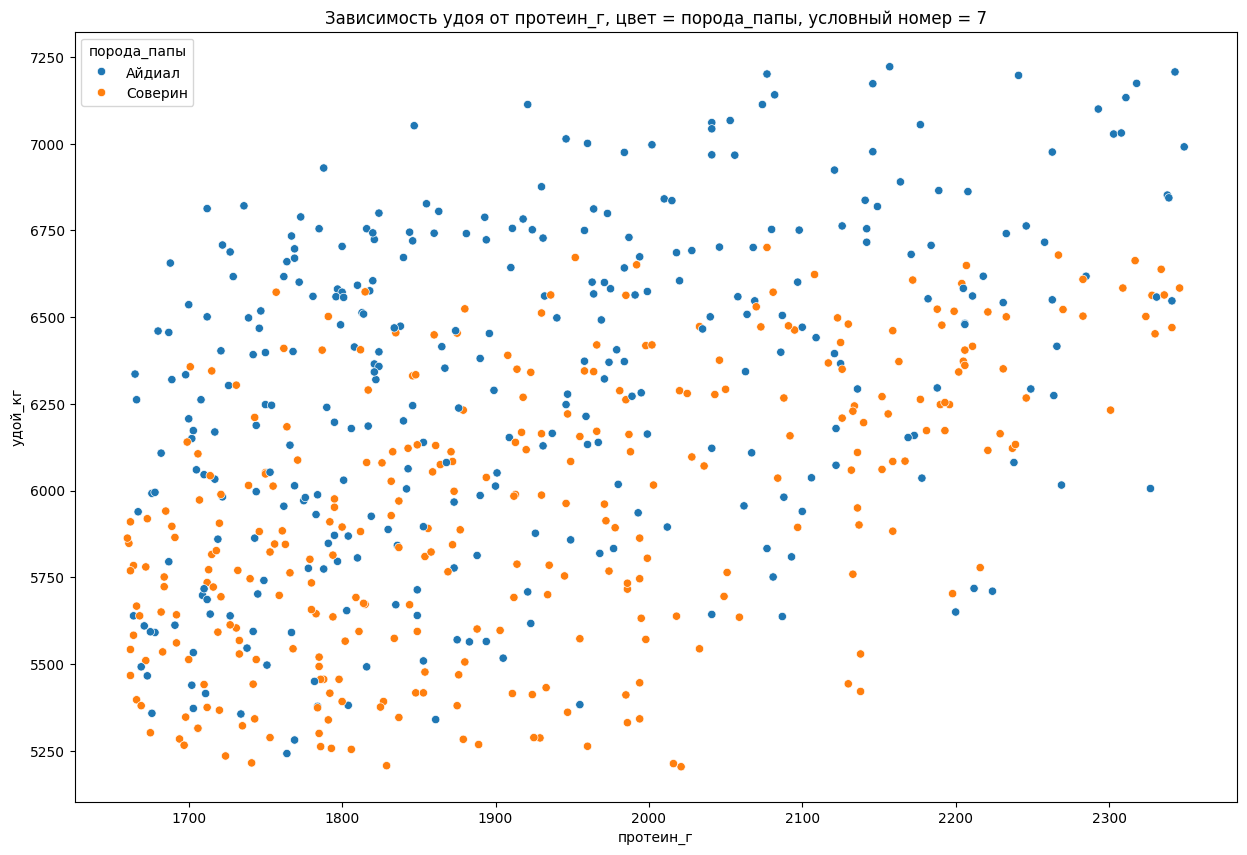

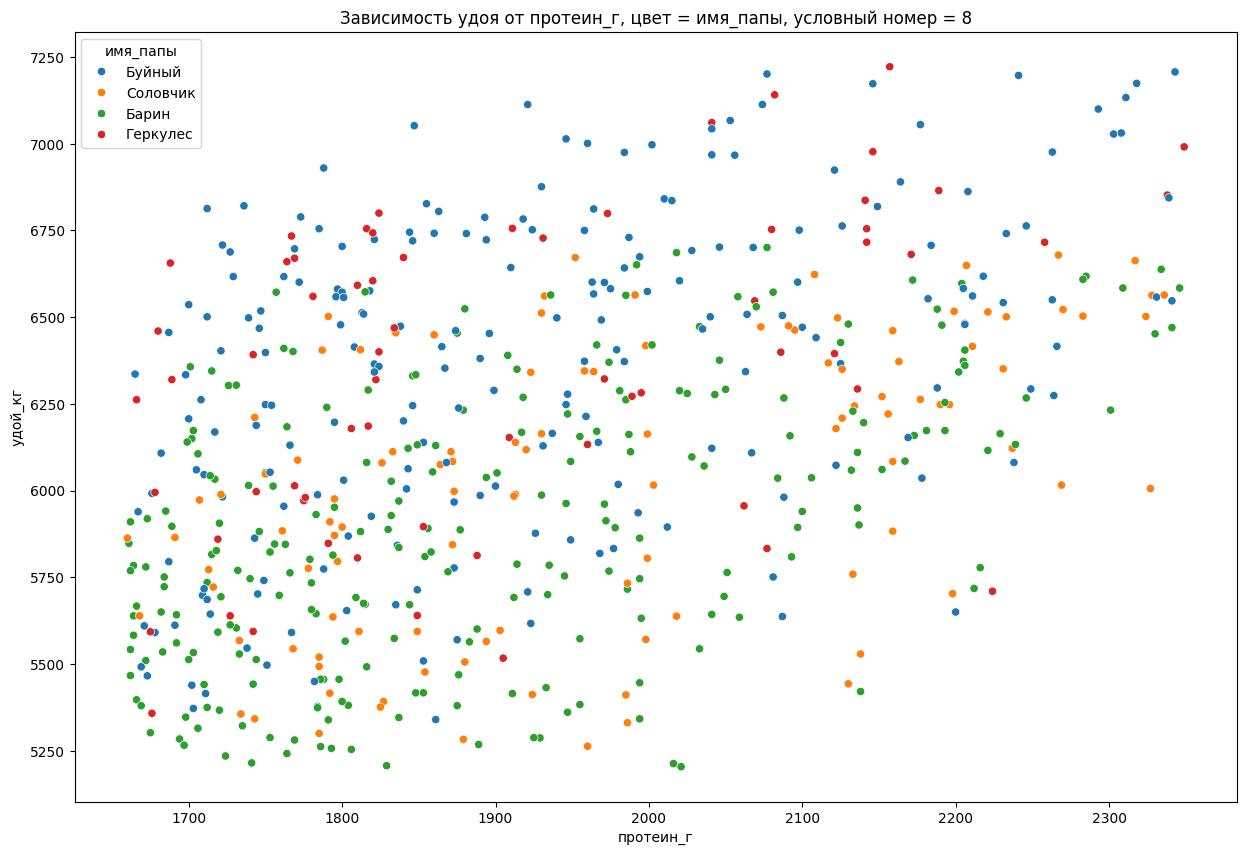


======================================== спо ========================================



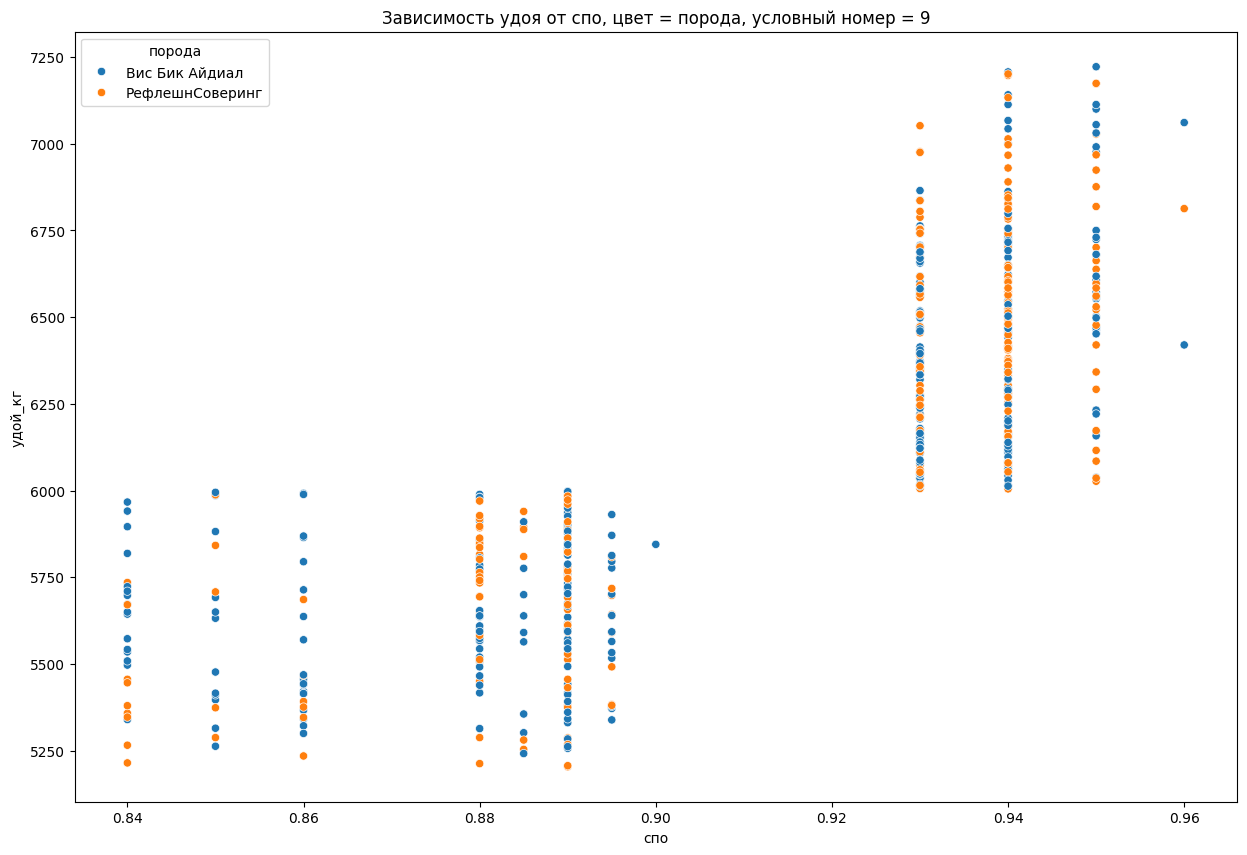

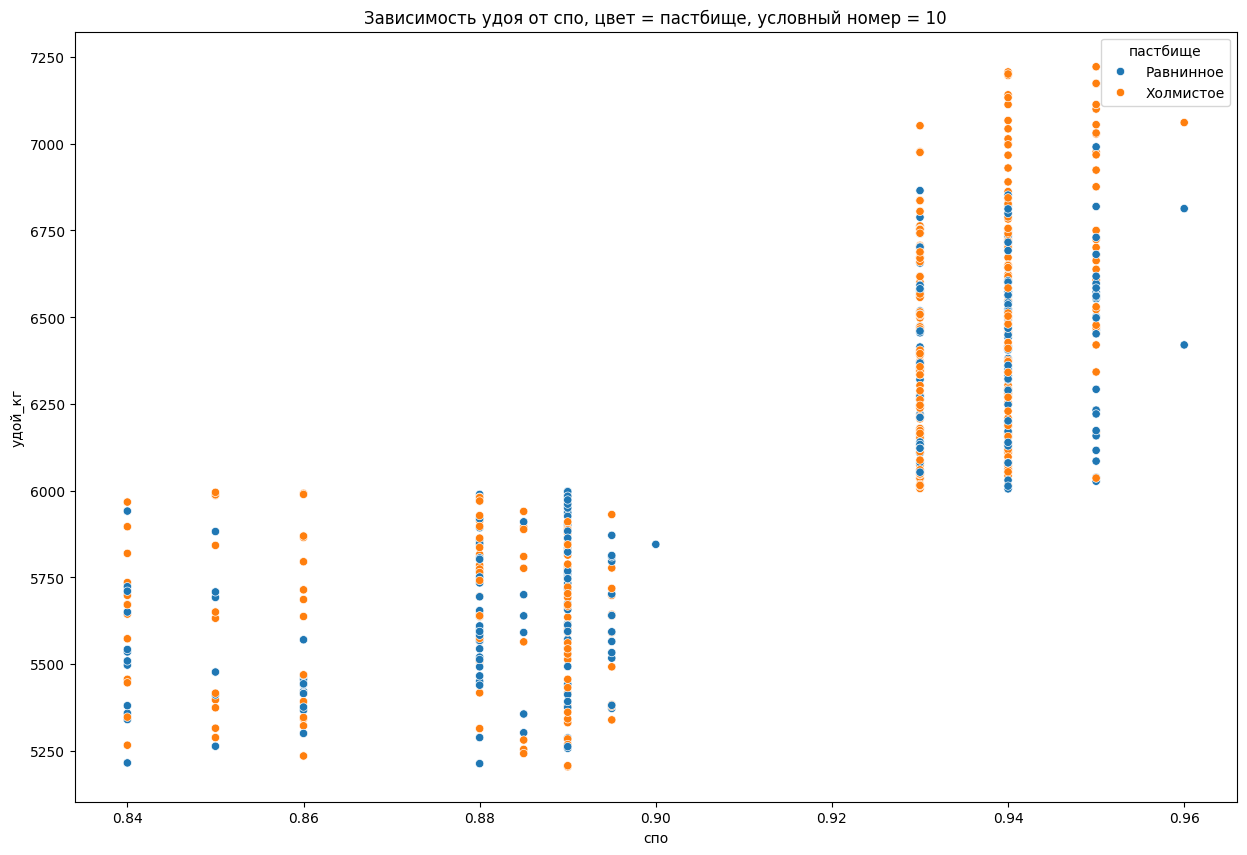

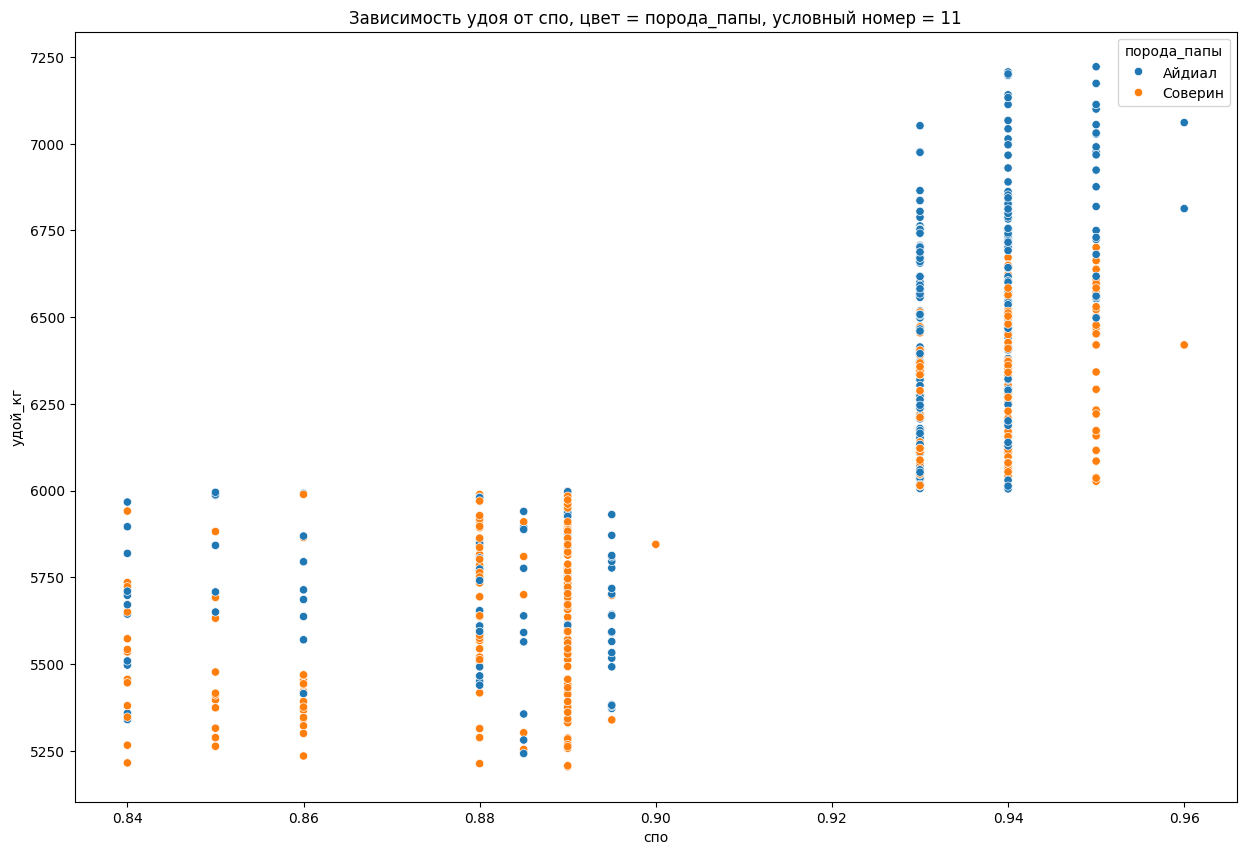

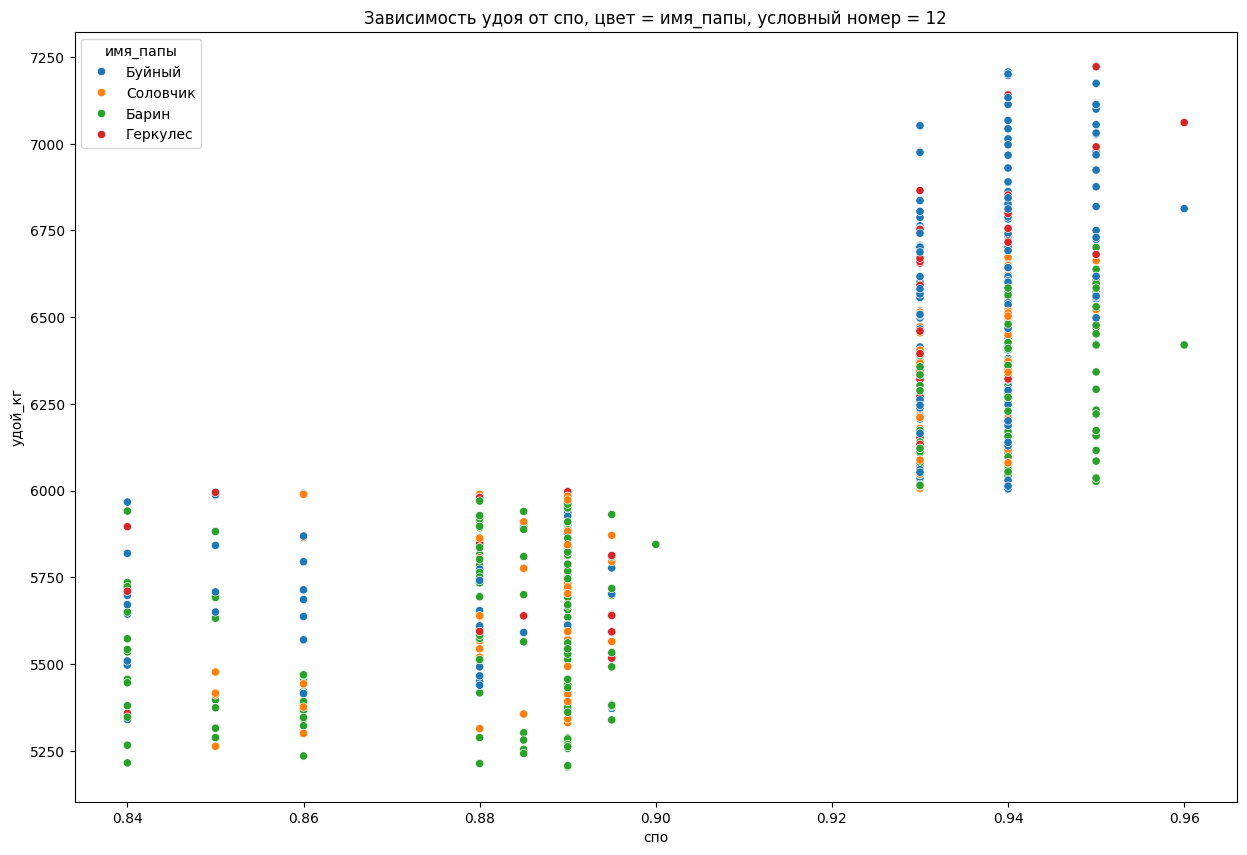


======================================== жирность_% ========================================



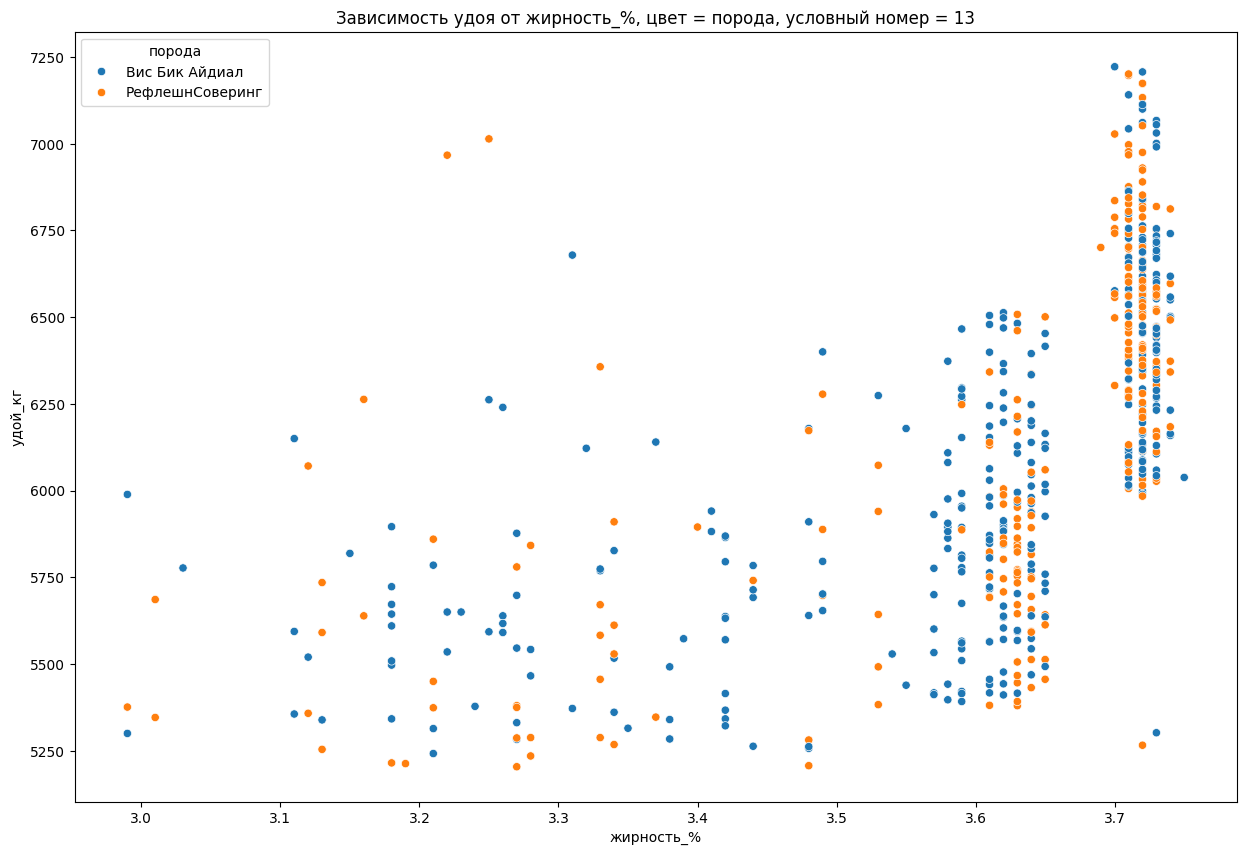

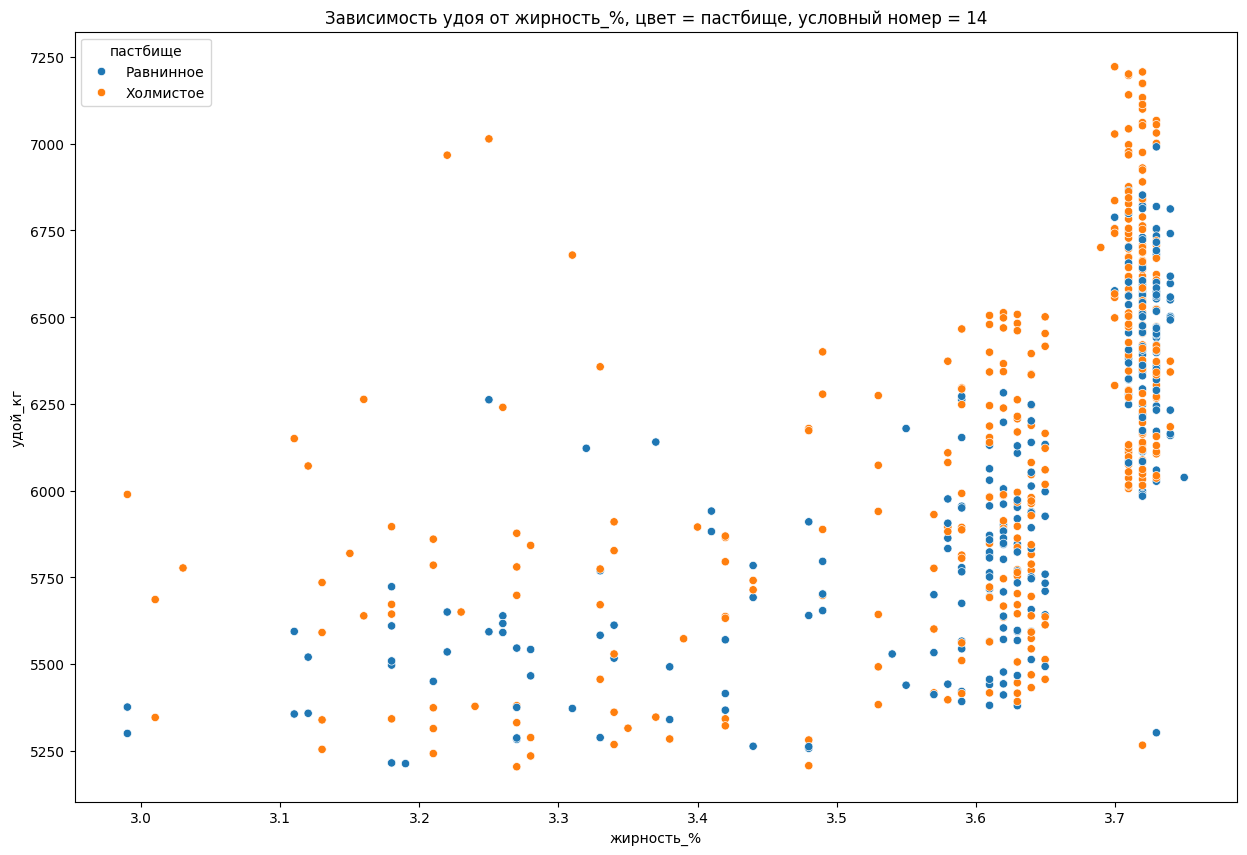

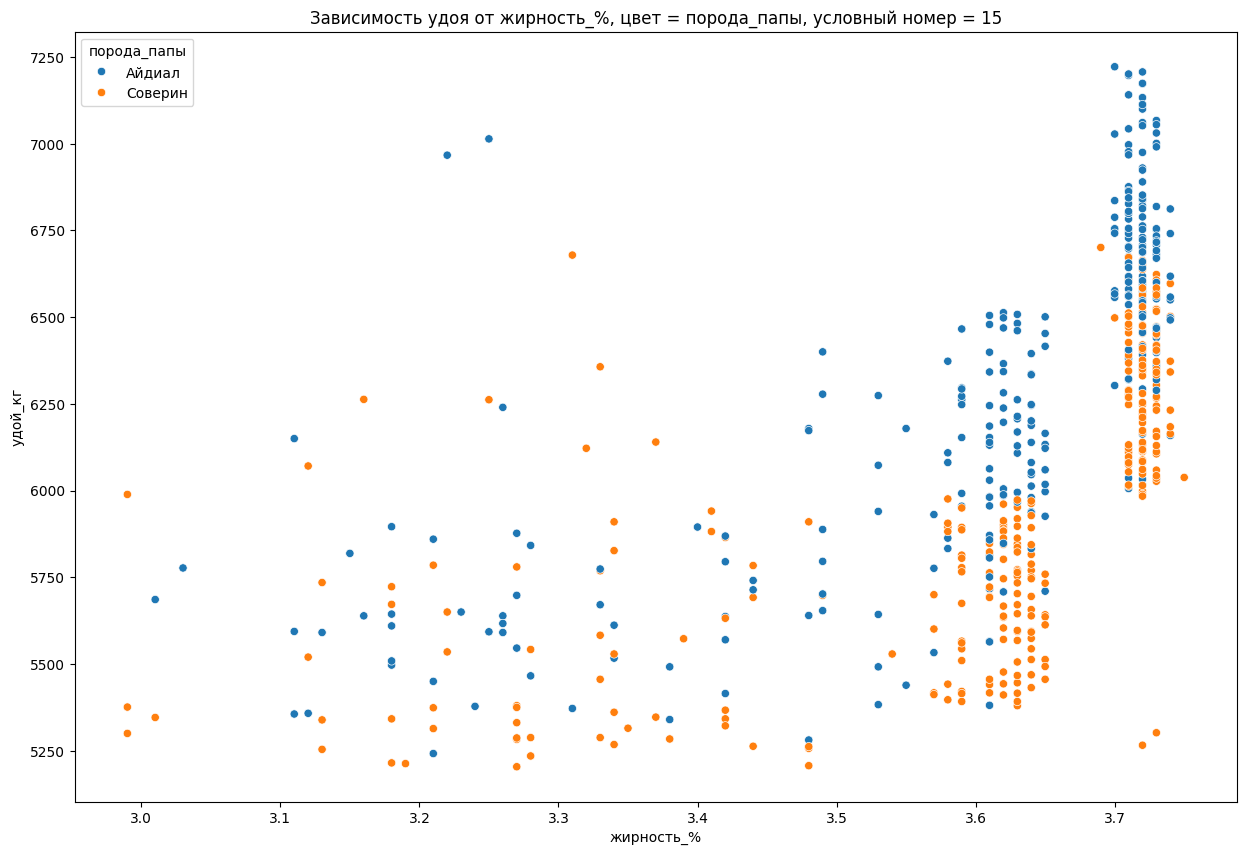

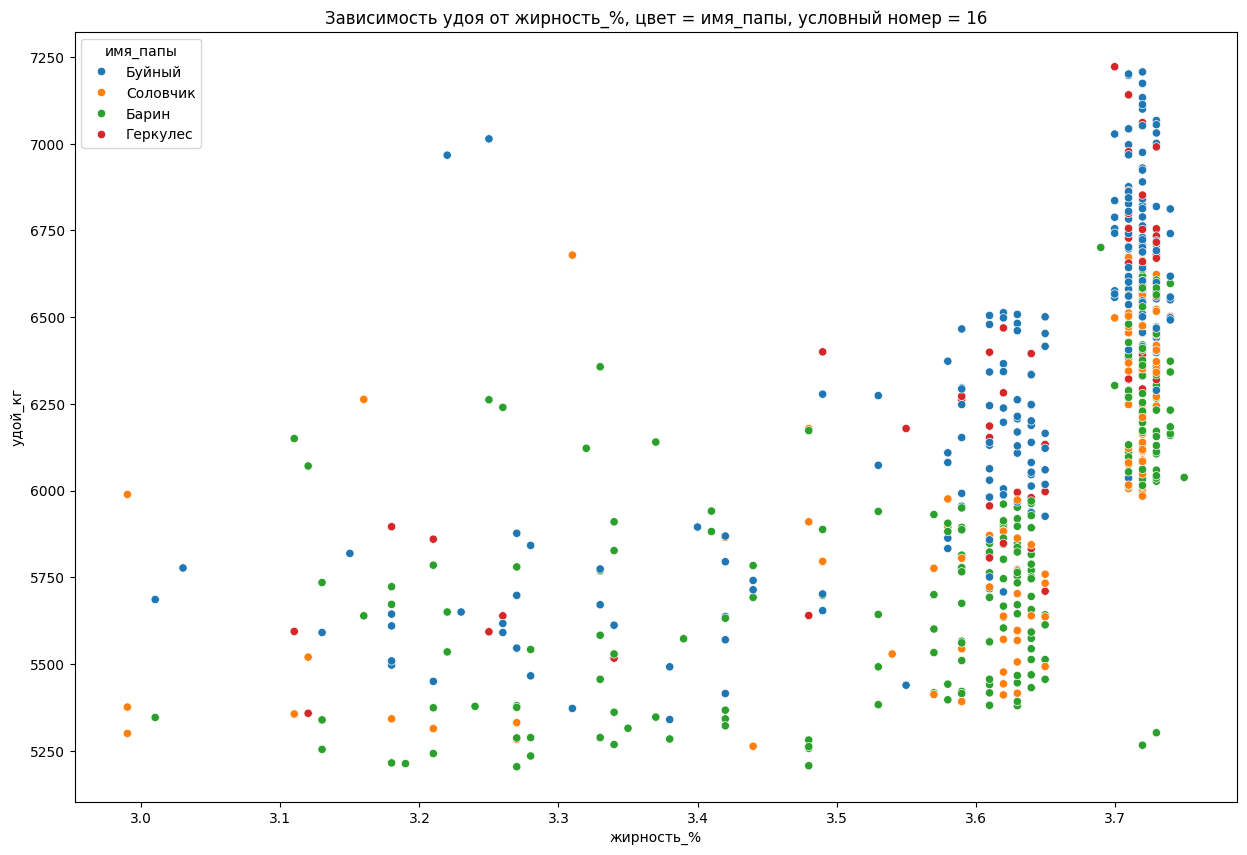


======================================== белок_% ========================================



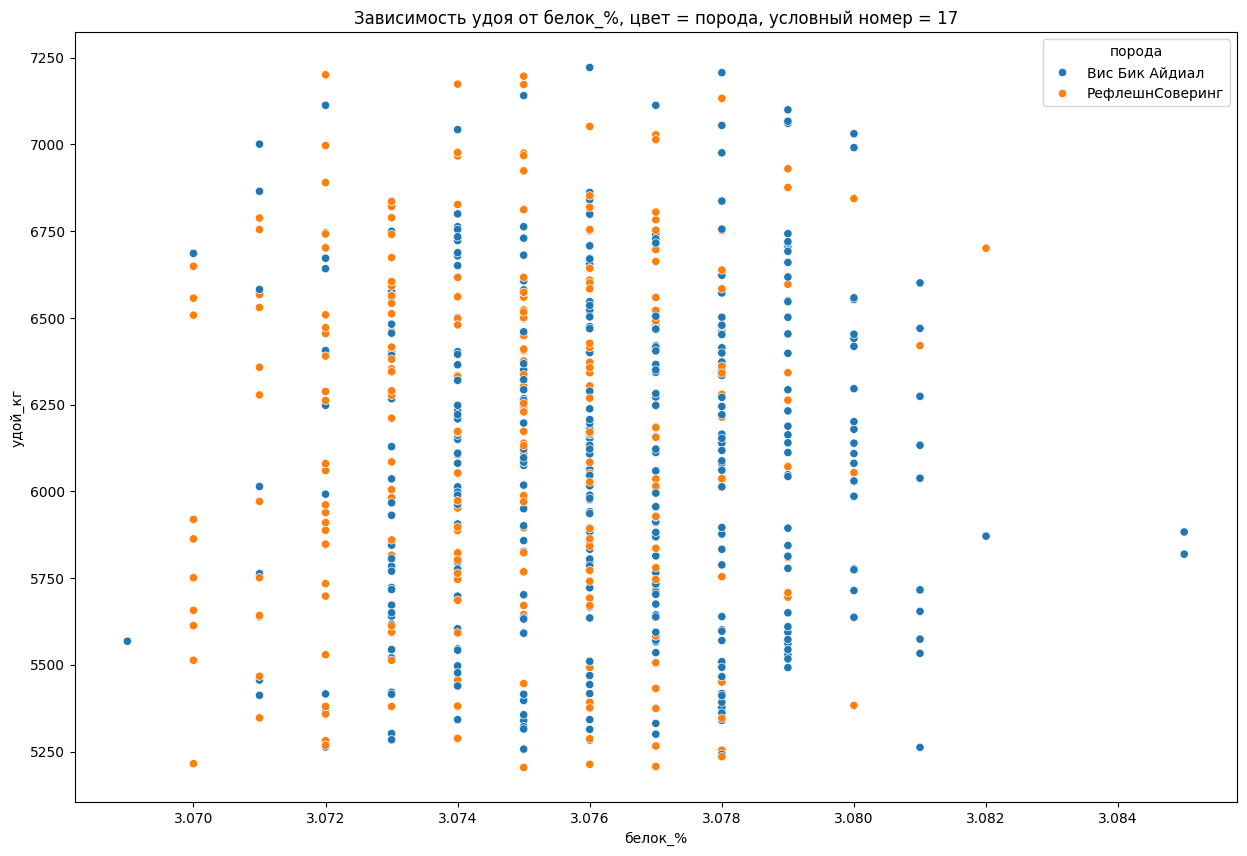

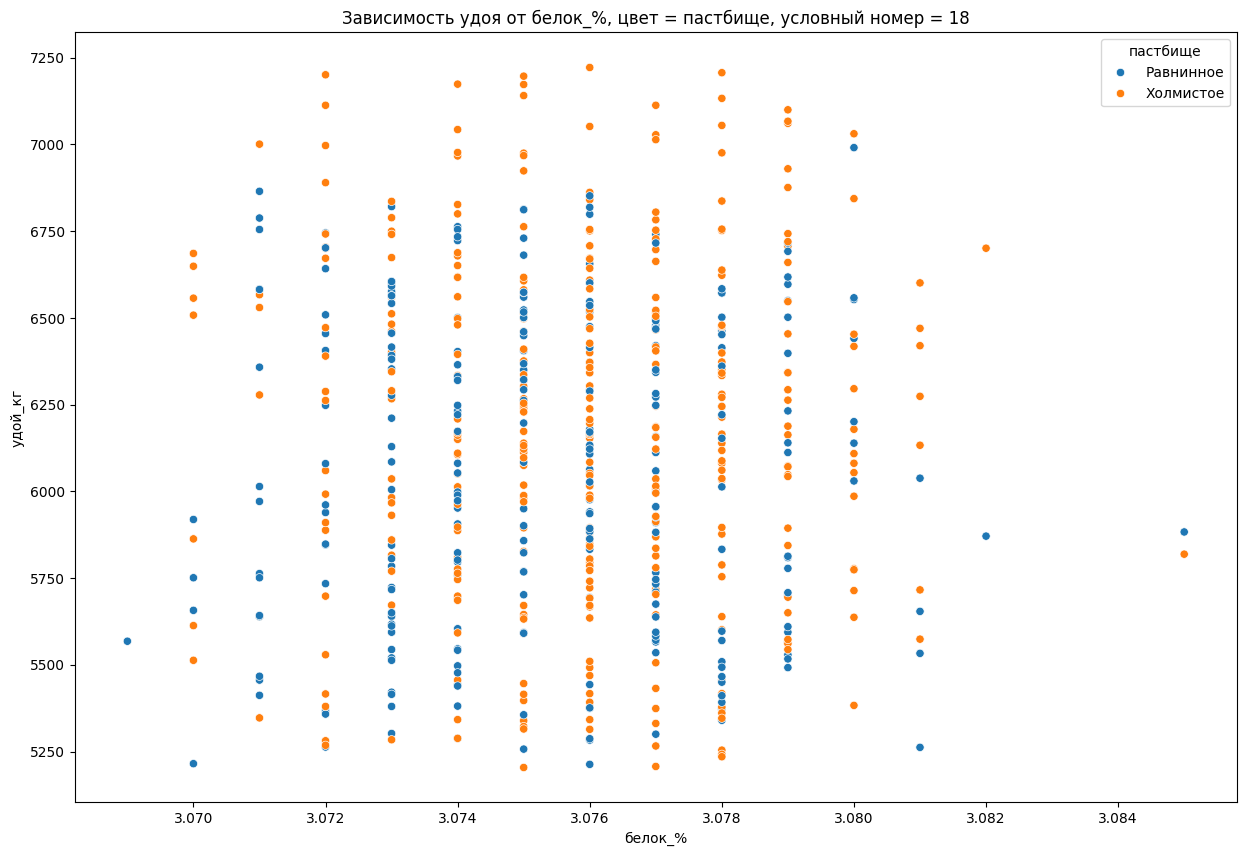

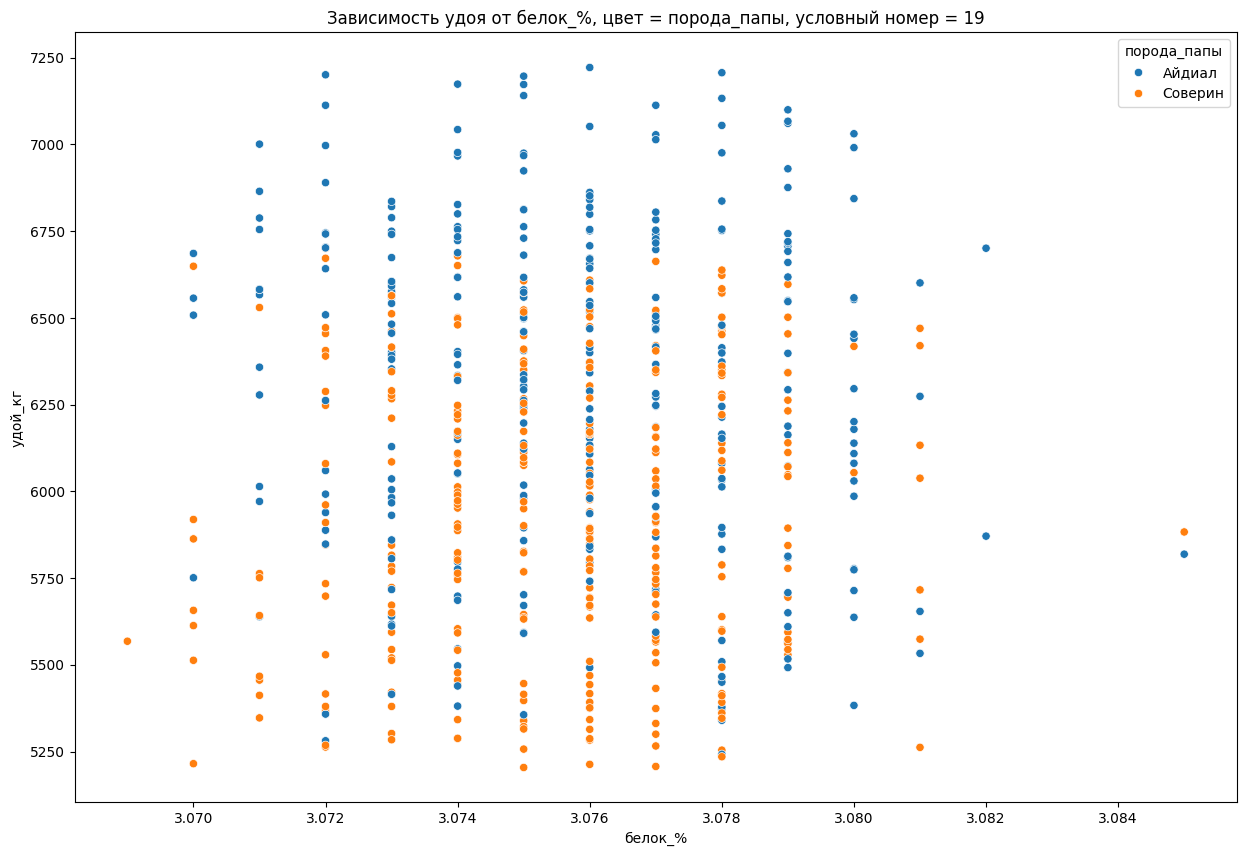

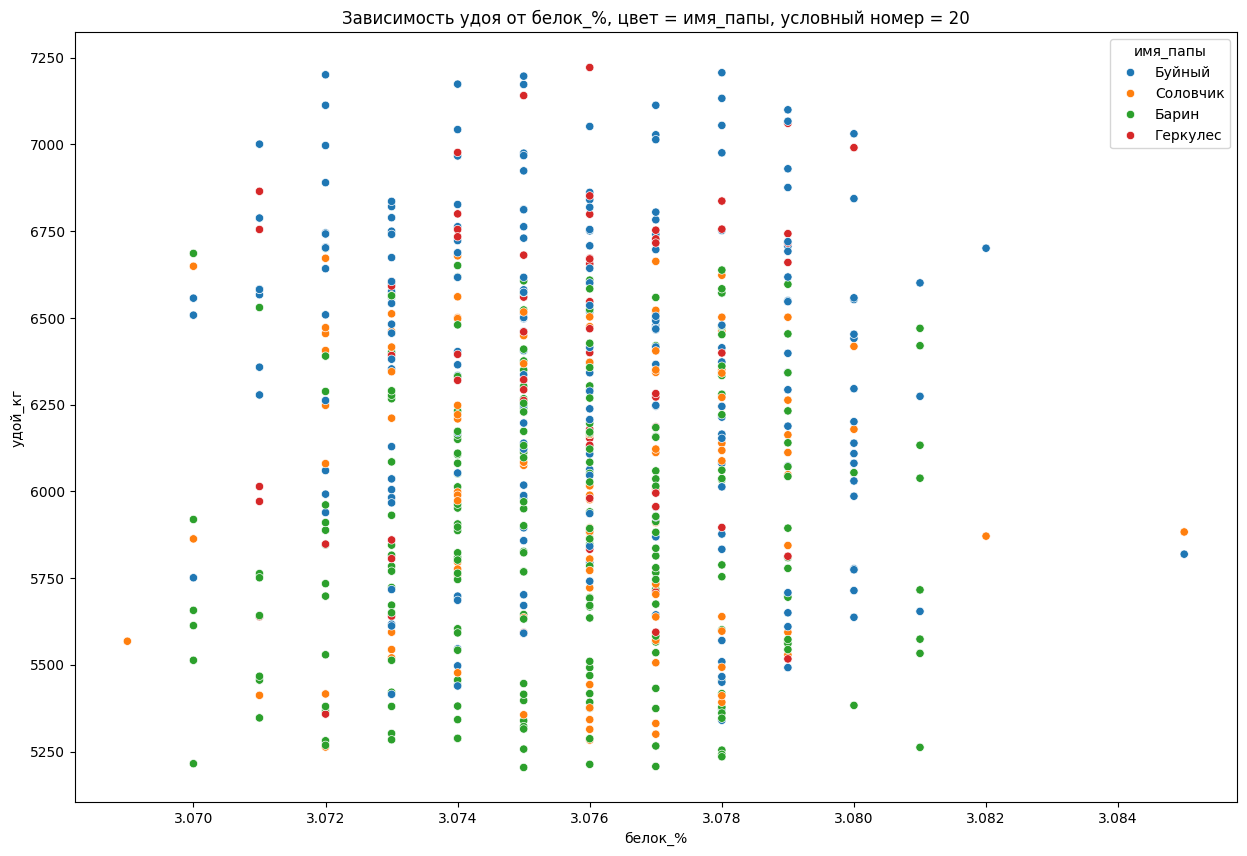

In [39]:
num_features = [
    'эке',
    'протеин_г',
    'спо',
    'жирность_%',
    'белок_%',
]           

cat_features = [
    'порода',
    'пастбище',
    'порода_папы',
    'имя_папы'
]

n = 1

for nf in num_features:
    
    print()
    print('=' * 40, nf, '=' * 40)
    print()
    
    for cf in cat_features:
        plt.figure(figsize=(15, 10))
        
        sns.scatterplot(
            data=ferma,
            x=nf,
            y='удой_кг',
            hue=cf
        )
        
        plt.title(f'Зависимость удоя от {nf}, цвет = {cf}, условный номер = {n}')
        plt.xlabel(nf)
        plt.ylabel('удой_кг')
        
        plt.show()
        
        n += 1

Список по условным номерам:
- 1-4 Корреляция удой-ЭКЕ отлично видна
	- зависимости от породы самой коровы нет
	- зависимости от типа пастбища коровы нет
	- зависимости от породы папы прослеживается - от дочек Айдиал удои чуть выше
	- дочки Буйного и Геркулеса (Айдиал) слегка систематически опережают дочек Барина и Соловчика (Соверин)

- 5-8 Корреляция удой-протеин видна слабо, на отдельных графиках кластеризации идентична 1-4

- 9-12 Корреляция удой-СПО отлично видна, на отдельных графиках кластеризации идентична 1-4, есть нелинейность.

- 13-16 Корреляция удой-жирность видна, на отдельных графиках кластеризации идентична 1-4

- 17-20 Корреляция удой-содержание белка совершенно не видна, на отдельных графиках кластеризации идентична 1-4

### Итог

Между количественными данными и целевыми признаками прослеживается корреляция.
Есть нелинейность зависимости между удоем и СПО.
Явной мультиколлинеарности между входными количественными признаками не видно, но она точно есть для пары имя-порода папы

## Обучение модели линейной регрессии

### Функции

In [40]:
def split_n_encode(
    X,
    y,
    num_features,
    cat_features,
    bin_features
):

    # train - test
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y,
        random_state=42
    )
    
    # one-hot
    encoder = OneHotEncoder(drop='first', sparse_output=False)

    X_train_ohe = encoder.fit_transform(X_train[cat_features])
    X_test_ohe = encoder.transform(X_test[cat_features])

    encoder_col_names = encoder.get_feature_names_out()

    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
    
    # standardization
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train[num_features])
    X_test_scaled = scaler.transform(X_test[num_features])

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_features)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_features)
    
    # объединение
    X_train = pd.concat([X_train_ohe, X_train_scaled, X_train[bin_features].reset_index(drop=True)], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_scaled, X_test[bin_features].reset_index(drop=True)], axis=1)
    
    return X_train, y_train, X_test, y_test, scaler, encoder

In [41]:
def metrics_n_residuals(
    y_test,
    y_pred
):

    print('=== Метрики ===')
    
    mae = mean_absolute_error(y_test, y_pred)
    print(f'MAE = {mae:.2f} кг')

    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    print(f'RMSE = {rmse:.2f} кг')

    r2 = r2_score(y_test, y_pred)
    print(f'R2 = {r2:.2f}\n')

    metrics = {
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }
    
    print('=== Остатки ===')
    
    res = y_test - y_pred

    plt.figure(figsize=(15, 20))

    ax1 = plt.subplot(211)

    ax1.hist(res, bins=20)

    plt.axvline(x=res.mean(), color='r', linestyle='--', label=f'среднее [{res.mean():.0f}]')
    plt.axvline(x=res.median(), color='r', linestyle=':', label=f'медиана [{res.median():.0f}]')

    plt.title('Распределение остатков')
    plt.ylabel('Количество')
    plt.xlabel('Остаток, кг')
    plt.legend()

    ax2 = plt.subplot(212)

    ax2.scatter(x=y_test, y=res)

    plt.axhline(y=0, color='k', linestyle='-')

    plt.title('Зависимость остатков')
    plt.xlabel('Удой, кг')
    plt.ylabel('Остаток, кг')

    ax1.grid()
    ax2.grid()

    plt.show()
    
    return metrics

In [42]:
def model_train(
    X,
    y,
    num_features,
    cat_features,
    bin_features
):
    
    X_train, y_train, X_test, y_test, scaler, encoder = split_n_encode(
        X,
        y,
        num_features,
        cat_features,
        bin_features
    )

    # model train, res quantiles
    model = LinearRegression()

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_train)
    
    res = y_train - y_pred
    
    qs = np.quantile(res, [0.025, 0.975])
    
    print(f'=== Квантили ошибки для доверительного интервала 95% ===\n{qs}\n')
    
    #test
    y_pred = model.predict(X_test)
    
    # metrics
    metrics = metrics_n_residuals(y_test, y_pred)
    
    metrics['q_2.5'] = qs[0]
    metrics['q_97.5'] = qs[1]
    
    return model, scaler, encoder, metrics

In [43]:
def cow_buy_encode(
    num_features,
    cat_features,
    bin_features,
    encoder,
    scaler
):

    # берём копию cow_buy из main
    X_test = cow_buy.copy()

    # согласно указанию
    for col in ['эке', 'протеин_г', 'спо']:
        mean_val = 1.05 * ferma[col].mean()
        X_test[col] = mean_val

    # доп категории
    X_test['спо_категория'] = X_test['спо'].apply(lambda x: x > 0.92)
    X_test['эке_2'] = X_test['эке'] ** 2
    
    # кодирование
    X_test_ohe = encoder.transform(X_test[cat_features])
    encoder_col_names = encoder.get_feature_names_out()
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

    X_test_scaled = scaler.transform(X_test[num_features])
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_features)

    X_test = pd.concat([X_test_ohe, X_test_scaled, X_test[bin_features].reset_index(drop=True)], axis=1)
    
    return X_test

### Модель 1

=== Квантили ошибки для доверительного интервала 95% ===
[-397.25510147  404.72208719]

=== Метрики ===
MAE = 161.78 кг
RMSE = 207.72 кг
R2 = 0.79

=== Остатки ===


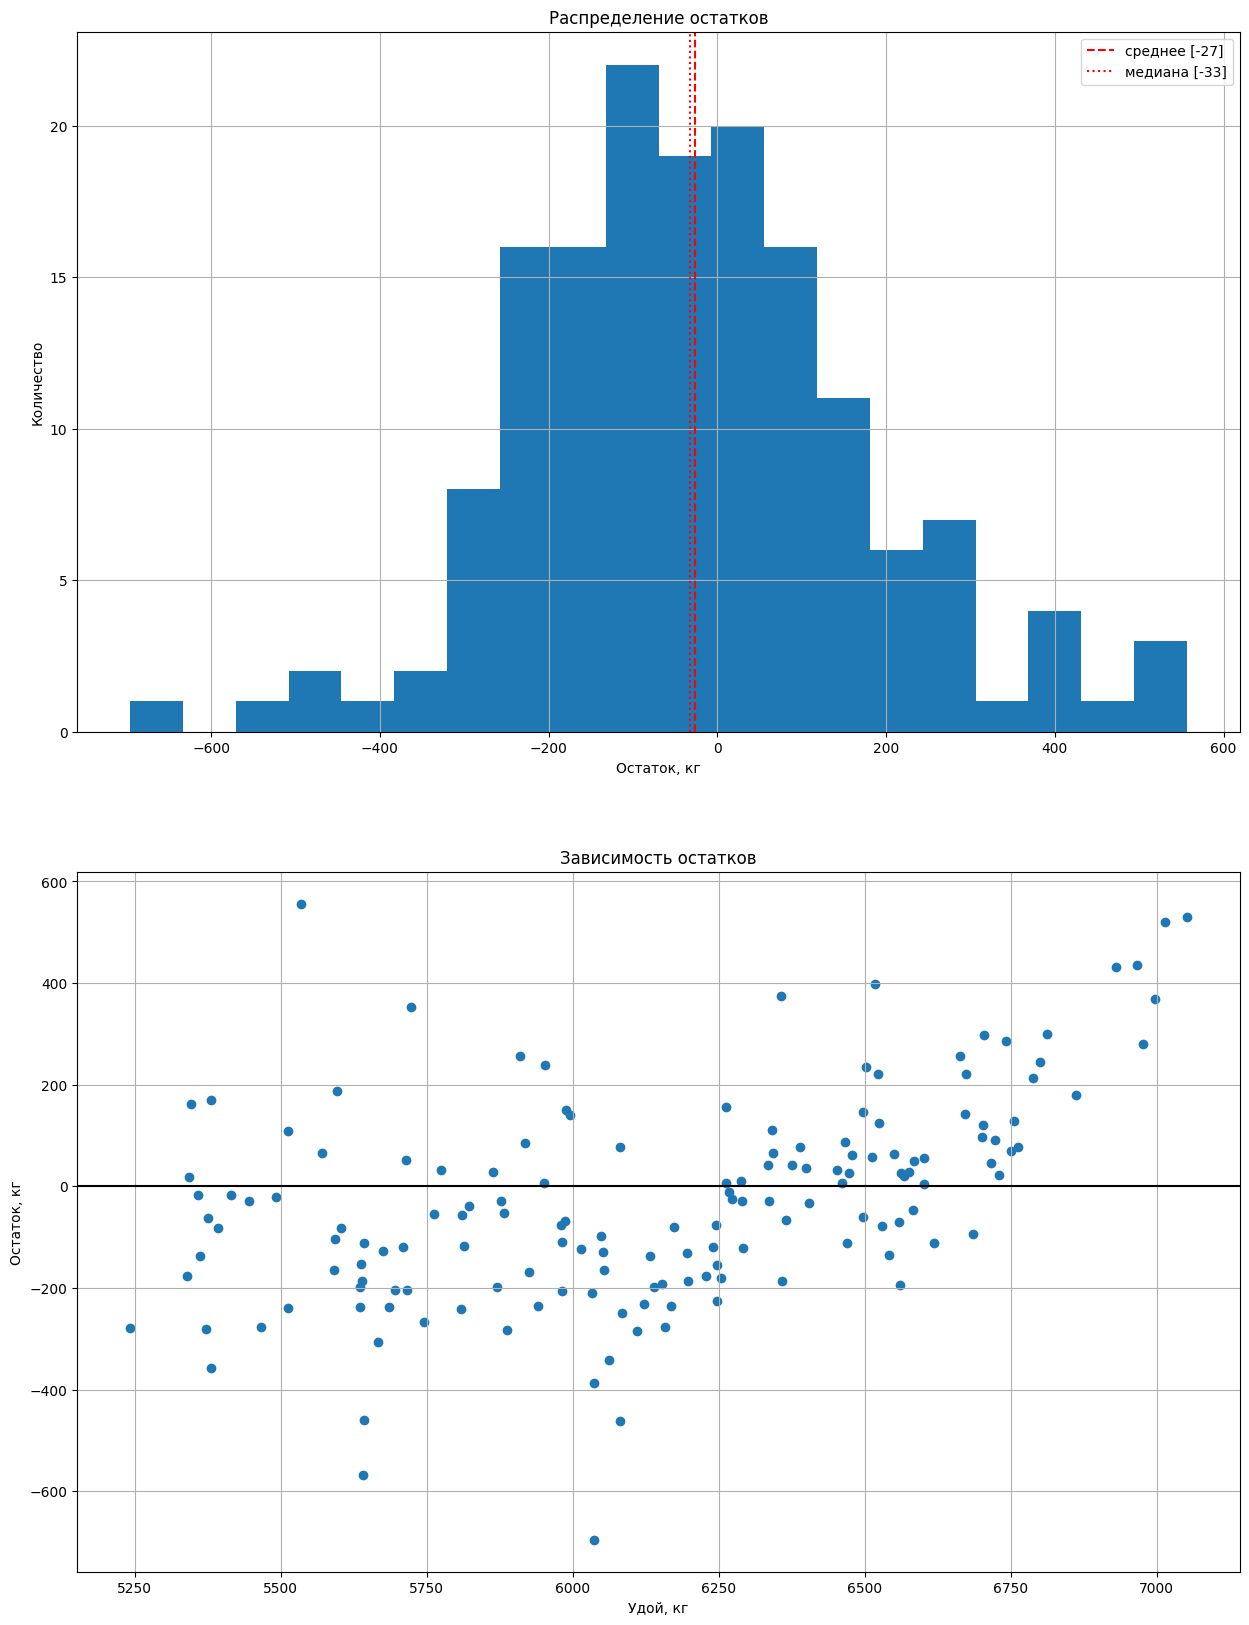

In [44]:
# связь с удоем возможна
num_features = ['эке', 'протеин_г', 'спо', 'жирность_%', 'белок_%']

# все кат. признаки из cow_buy (кроме имени папы), могут влиять на удой
cat_features = ['порода', 'пастбище', 'порода_папы']

# явно влияет на удой, есть в cow_buy
bin_features = ['возраст_2+']


X = ferma[num_features + cat_features + bin_features]
y = ferma['удой_кг']


model_lin1, scaler_lin1, encoder_lin1, metrics_lin1 = model_train(
    X,
    y,
    num_features,
    cat_features,
    bin_features
)

На обучающей выборке модель в 95% случаев промахивается меньше, чем на 400 кг

Метрики выглядят адекватно

Распределение остатков почти симметричное, центр немного смещён в отрицательную область.

Зависимость остатка от величины показывает, что для предсказания больших значений удоя предсказания систематически занижены

### Модель 2
Сделаем дополнительные признаки

In [45]:
ferma['спо_категория'] = ferma['спо'].apply(lambda x: x > 0.92)

In [46]:
ferma['эке_2'] = ferma['эке'] ** 2

=== Квантили ошибки для доверительного интервала 95% ===
[-355.93370351  392.72329038]

=== Метрики ===
MAE = 146.69 кг
RMSE = 192.04 кг
R2 = 0.82

=== Остатки ===


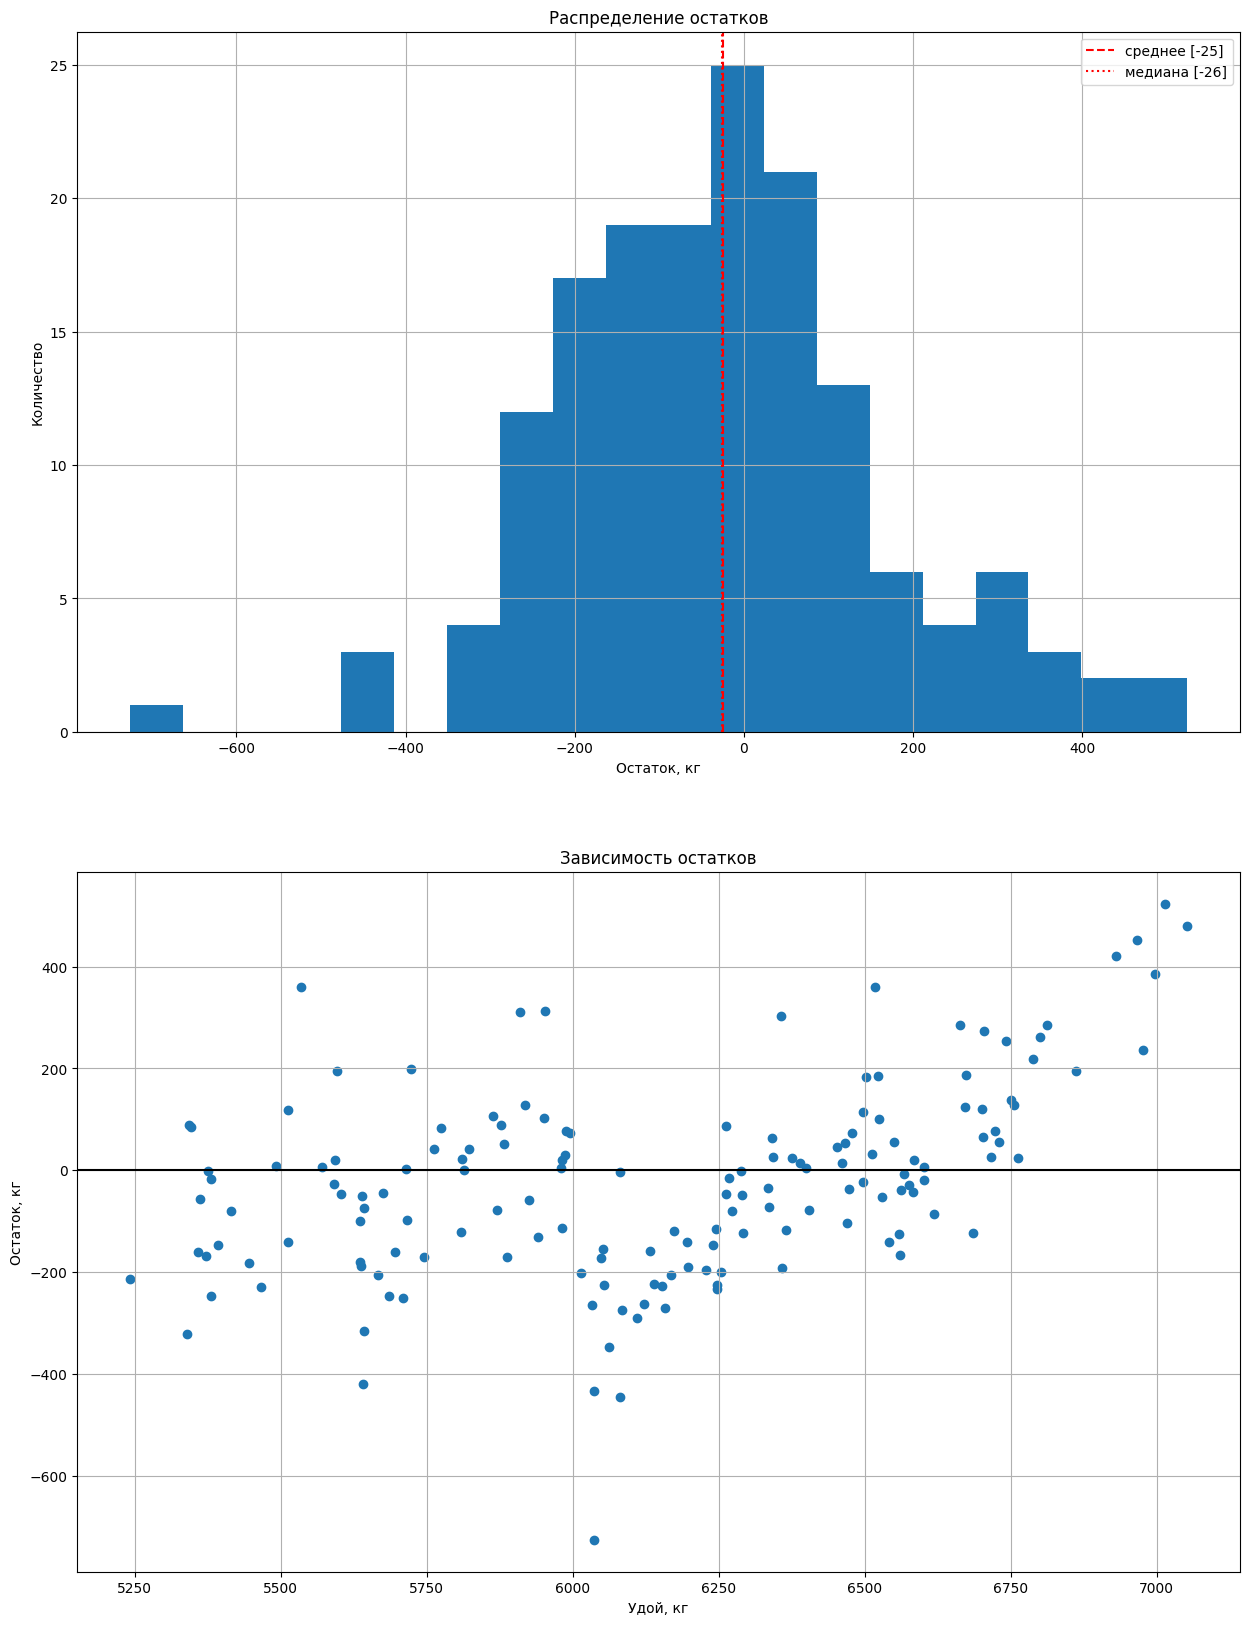

In [47]:
# связь с удоем возможна
num_features = ['эке_2', 'протеин_г', 'жирность_%', 'белок_%']

# все кат. признаки из cow_buy (кроме имени папы), могут влиять на удой
cat_features = ['порода', 'пастбище', 'порода_папы']

# возраст явно влияет на удой, есть в cow_buy + спо в виде категории
bin_features = ['возраст_2+', 'спо_категория']


X = ferma[num_features + cat_features + bin_features]
y = ferma['удой_кг']


model_lin2, scaler_lin2, encoder_lin2, metrics_lin2 = model_train(
    X,
    y,
    num_features,
    cat_features,
    bin_features
)

На обучающей выборке модель стала точнее, в первую очередь в плане занижения (на 10 % меньше квантиль 2.5%)

Метрики стали чуть лучше

Распределение остатков почти симметричное, среднее и медиана немного смещёны в отрицательную область чуть меньше чем для модели 1.

Зависимость остатка от величины показывает, что для предсказания больших значений удоя предсказания опять систематически занижены

### Модель 3
И ещё признаки

=== Квантили ошибки для доверительного интервала 95% ===
[-341.70854077  362.75259725]

=== Метрики ===
MAE = 143.49 кг
RMSE = 188.29 кг
R2 = 0.83

=== Остатки ===


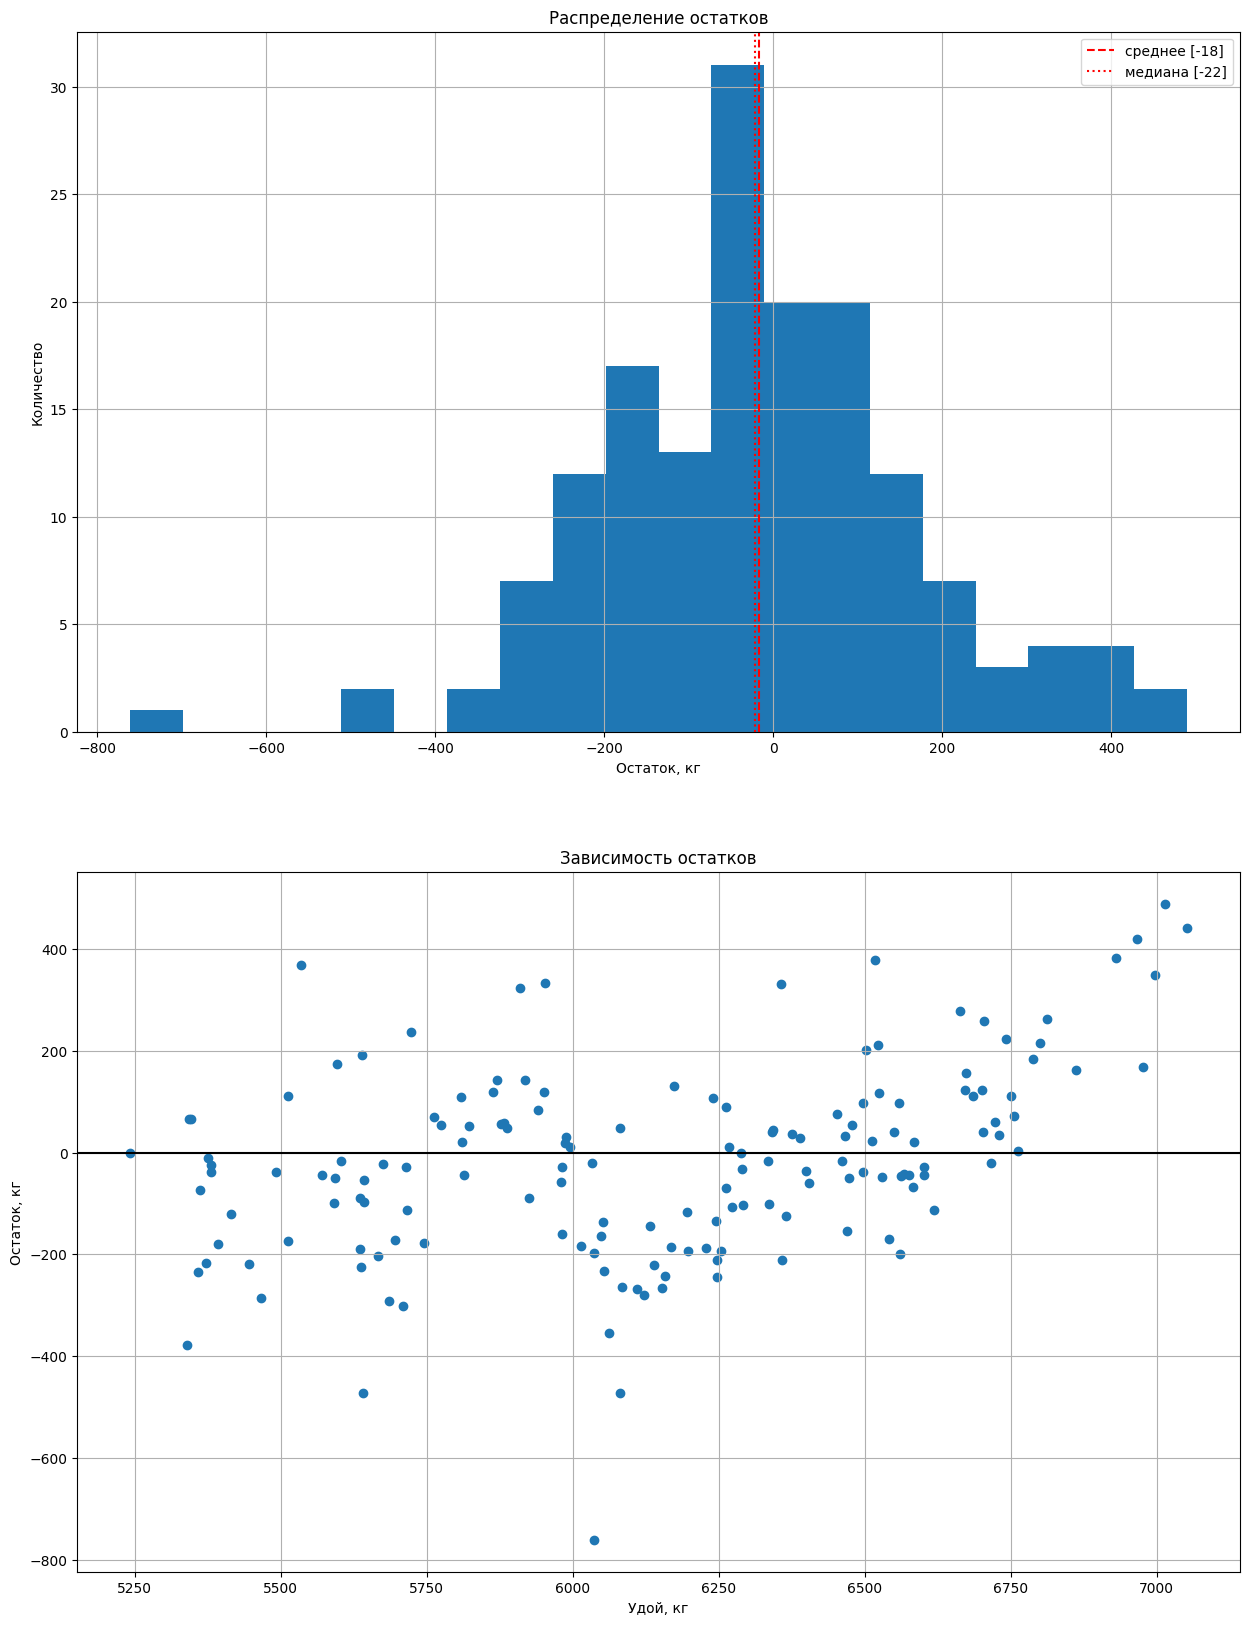

In [48]:
# связь с удоем возможна
num_features = ['эке_2', 'протеин_г', 'жирность_%', 'белок_%']

# все кат. признаки из cow_buy (кроме породы папы), могут влиять на удой
cat_features = ['порода', 'пастбище', 'имя_папы']

# возраст явно влияет на удой, есть в cow_buy + спо в виде категории
bin_features = ['возраст_2+', 'спо_категория']


X = ferma[num_features + cat_features + bin_features]
y = ferma['удой_кг']


model_lin3, scaler_lin3, encoder_lin3, metrics_lin3 = model_train(
    X,
    y,
    num_features,
    cat_features,
    bin_features
)

На обучающей выборке модель ошибки ещё упали

Метрики стали ещё чуть лучше

Распределение остатков почти симметричное, среднее и медиана стали ещё ближе к 0

Зависимость остатка от величины показывает, что для предсказания больших значений удоя предсказания опять систематически занижены

Соберем данные в таблицу

In [49]:
pd.DataFrame(
    index=[f'Модель {i}' for i in range(1, 4)],
    data=[metrics_lin1, metrics_lin2, metrics_lin3]
).round(3)

mae     rmse     r2    q_2.5   q_97.5
Модель 1  161.781  207.718  0.788 -397.255  404.722
Модель 2  146.695  192.040  0.819 -355.934  392.723
Модель 3  143.489  188.290  0.826 -341.709  362.753

В ряду 1-3 качество модели монотонно растёт по всем метрикам: отклонения RMSE и MAE снижаются, R2 растёт. 
Также уменьшается и ширина доверительного интервала 95%.

Отдельно сравнивать MSE нет особого смысла:
- она монотонно зависит от RMSE
- квадратные кг удоя не очень информативны


Однозначно, надо использовать модель 3 - она лучше по всем параметрам.
Доверительный интервал оошибки для неё: от -341 до 362 кг.

### Предсказание для данных из cow_buy

In [50]:
# данные для обучения
num_features = ['эке_2', 'протеин_г', 'жирность_%', 'белок_%']

cat_features = ['порода', 'пастбище', 'имя_папы']

bin_features = ['возраст_2+', 'спо_категория']


X_test = cow_buy_encode(
    num_features,
    cat_features,
    bin_features,
    encoder_lin3,
    scaler_lin3
)

# предсказание удоя
y_pred = model_lin3.predict(X_test)


cow_buy['удой_кг_(пред)'] = y_pred

cow_buy['удой_кг_(пред,мин)'] = y_pred + metrics_lin3['q_2.5']

cow_buy['удой_кг_(пред,макс)'] = y_pred + metrics_lin3['q_97.5']

columns = cow_buy.columns.str.contains('удой_кг')
cow_buy.loc[:, columns] = cow_buy.loc[:, columns].round()

cow_buy

cow_buy           порода   пастбище порода_папы  имя_папы  жирность_%  \
0         Вис Бик Айдиал  Холмистое      Айдиал  Геркулес        3.58   
1         Вис Бик Айдиал  Равнинное     Соверин    Буйный        3.54   
2        РефлешнСоверинг  Равнинное     Соверин     Барин        3.59   
3        РефлешнСоверинг  Холмистое      Айдиал    Буйный        3.40   
4        РефлешнСоверинг  Равнинное      Айдиал    Буйный        3.64   
5        РефлешнСоверинг  Равнинное     Соверин  Геркулес        3.63   
6         Вис Бик Айдиал  Холмистое      Айдиал  Геркулес        3.58   
7         Вис Бик Айдиал  Равнинное     Соверин    Буйный        3.57   
8        РефлешнСоверинг  Равнинное     Соверин     Барин        3.59   
9        РефлешнСоверинг  Холмистое      Айдиал    Буйный        3.40   
10        Вис Бик Айдиал  Холмистое     Соверин  Соловчик        3.73   
11       РефлешнСоверинг  Равнинное     Соверин  Геркулес        3.73   
12        Вис Бик Айдиал  Холмистое      Айдиал  Геркулес        3.68   
13        Вис Бик Айдиал  Холмистое     Соверин     Барин        3.42   
14       РефлешнСоверинг  Равнинное     Соверин     Барин        3.59   
15       РефлешнСоверинг  Холмистое      Айдиал    Буйный        3.40   
16        Вис Бик Айдиал  Холмистое     Соверин  Соловчик        3.73   
17       РефлешнСоверинг  Равнинное     Соверин  Геркулес        3.77   
18        Вис Бик Айдиал  Равнинное     Соверин    Буйный        3.34   
19       РефлешнСоверинг  Равнинное      Айдиал    Буйный        3.64   

cow_buy  белок_%  возраст_2+  удой_кг_(пред)  удой_кг_(пред,мин)  \
0          3.076        True          6597.0              6255.0   
1          3.081       False          6274.0              5933.0   
2          3.074        True          6262.0              5920.0   
3          3.061        True          6690.0              6349.0   
4          3.074        True          6542.0              6200.0   
5          3.053       False          6600.0              6259.0   
6          3.076        True          6597.0              6255.0   
7          3.079        True          6479.0              6137.0   
8          3.074        True          6262.0              5920.0   
9          3.079       False          6327.0              5985.0   
10         3.055        True          6568.0              6226.0   
11         3.073        True          6592.0              6251.0   
12         3.046        True          6926.0              6584.0   
13         3.075       False          6105.0              5763.0   
14         3.074        True          6262.0              5920.0   
15         3.065        True          6649.0              6307.0   
16         3.079        True          6321.0              5979.0   
17         3.053       False          6629.0              6287.0   
18         3.069        True          6536.0              6194.0   
19         3.074        True          6542.0              6200.0   

cow_buy  удой_кг_(пред,макс)  
0                     6960.0  
1                     6637.0  
2                     6625.0  
3                     7053.0  
4                     6904.0  
5                     6963.0  
6                     6960.0  
7                     6842.0  
8                     6625.0  
9                     6690.0  
10                    6931.0  
11                    6955.0  
12                    7289.0  
13                    6468.0  
14                    6625.0  
15                    7012.0  
16                    6684.0  
17                    6991.0  
18                    6898.0  
19                    6904.0

### Итог

Для решения задачи предсказания удоя было сделано 3 модели. 
В самой простой модели с признаками были выполнены только минимально необходимые для нормального функционирования линейной регрессии преобразования.
Во второй модели количественный признак СПО был сведён к бинарному, а ЭКЕ взят в квадрате, так как это лучше соответствует наблюдаемой корреляции.
В третьей дополнительно вместо породы папы быка было взято имя папы быка.

В результате было установлено, что модель 3 характеризуется лучшей точностью, и именно стоит использовать для предсказания удоя от коров, которые "ЭкоФерма" предлагает "Вольному лугу" 

## Обучение модели логистической регрессии

### Функции

In [51]:
def log_metrics(
    y_test,
    y_pred,
    verbose
):

    # метрики
    ac = accuracy_score(y_test, y_pred)
    pr = precision_score(y_test, y_pred)
    rc = recall_score(y_test, y_pred)
    
    cm = confusion_matrix(y_test, y_pred)
    
    metrics = {
        'ac': ac,
        'pr': pr,
        'rc': rc,
        'cm': cm
    }

    # выдача
    if verbose:
        print('=== Метрики ===')
        
        print(f'Accuracy = {ac:.2f}')
        print(f'Precision = {pr:.2f}')
        print(f'Recall = {rc:.2f}\n')
        
        print('=== Матрица ошибок ===')
    
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.ylabel('Реальность')
        plt.xlabel('Предсказание')
    
        plt.show()
    
    return metrics

In [52]:
def log_model_train(
    X,
    y,
    num_features,
    cat_features,
    bin_features,
    th,
    verbose=False
):
    
    X_train, y_train, X_test, y_test, scaler, encoder = split_n_encode(
        X,
        y,
        num_features,
        cat_features,
        bin_features
    )

    # model train
    model = LogisticRegression()

    model.fit(X_train, y_train)
    
    #test
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    y_pred = y_pred_proba > th
    
    # metrics
    metrics = log_metrics(y_test, y_pred, verbose)
    
    return model, scaler, encoder, metrics

### Обучение и метрики

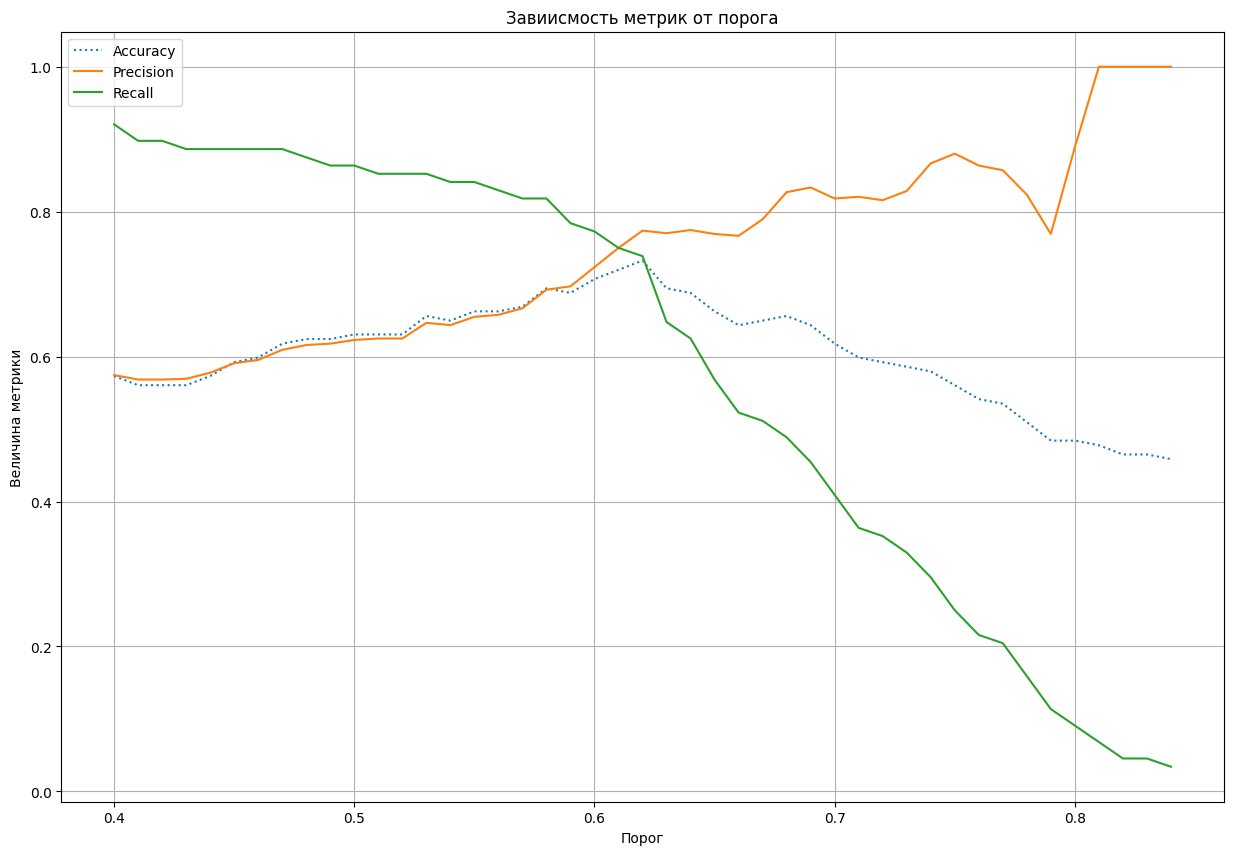

In [53]:
# связь с удоем возможна
num_features = ['эке_2', 'протеин_г', 'жирность_%', 'белок_%']

# все кат. признаки из cow_buy (кроме породы папы), могут влиять на удой
cat_features = ['порода', 'пастбище', 'имя_папы']

# возраст явно влияет на удой, есть в cow_buy + спо в виде категории
bin_features = ['возраст_2+', 'спо_категория']


X = ferma[num_features + cat_features + bin_features]
y = ferma['вкус']

# потестируем разные пороги
thresholds = np.arange(0.4, 0.85, 0.01).round(2)

accuracy = []
precision = []
recall = []

for th in thresholds:
    #print(f'\n*** Порог = {th} ***\n')
    _, _, _, metrics = log_model_train(
        X,
        y,
        num_features,
        cat_features,
        bin_features,
        th
    )
    
    accuracy.append(metrics['ac'])
    precision.append(metrics['pr'])
    recall.append(metrics['rc'])

plt.figure(figsize=(15, 10))

plt.title('Завиисмость метрик от порога')
plt.xlabel('Порог')
plt.ylabel('Величина метрики')

plt.plot(thresholds, accuracy, ':', label='Accuracy')
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, recall, label='Recall')

plt.legend()
plt.grid()

plt.show()

Похоже, ключевой метрикой можно считать precision, так как фермеру важно, чтобы молоко было вкусным.
С этой точки зрения оптимальный порог равен 0.75:
- при более низких значениях порога precision сильно проседает
- при более высоких очень быстро падают accuracy и recall, а precision особо не растёт

=== Метрики ===
Accuracy = 0.62
Precision = 0.82
Recall = 0.41

=== Матрица ошибок ===


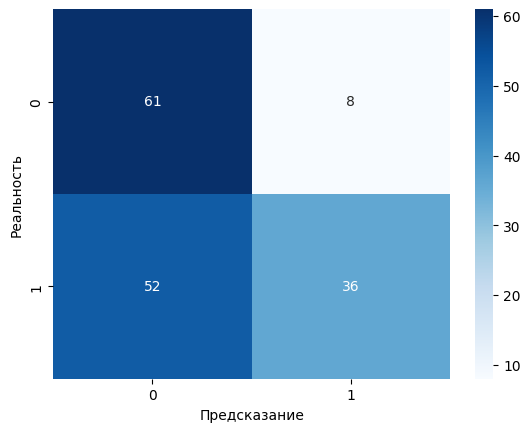

In [54]:
# модель с оптимальным порогом
model_log, scaler_log, encoder_log, metrics_log = log_model_train(
    X,
    y,
    num_features,
    cat_features,
    bin_features,
    0.7,
    True
)

### Предсказание для данных из cow_buy

In [55]:
# данные для обучения
num_features = ['эке_2', 'протеин_г', 'жирность_%', 'белок_%']

cat_features = ['порода', 'пастбище', 'имя_папы']

bin_features = ['возраст_2+', 'спо_категория']


X_test = cow_buy_encode(
    num_features,
    cat_features,
    bin_features,
    encoder_log,
    scaler_log
)


# предсказание вкуса
# пришлось уменьшить порог до 0.7 - иначе вообще ни одна корова не проходит
y_pred = model_log.predict_proba(X_test)[:, 1] > 0.7

cow_buy['вкус_(пред)'] = y_pred

cow_buy

cow_buy           порода   пастбище порода_папы  имя_папы  жирность_%  \
0         Вис Бик Айдиал  Холмистое      Айдиал  Геркулес        3.58   
1         Вис Бик Айдиал  Равнинное     Соверин    Буйный        3.54   
2        РефлешнСоверинг  Равнинное     Соверин     Барин        3.59   
3        РефлешнСоверинг  Холмистое      Айдиал    Буйный        3.40   
4        РефлешнСоверинг  Равнинное      Айдиал    Буйный        3.64   
5        РефлешнСоверинг  Равнинное     Соверин  Геркулес        3.63   
6         Вис Бик Айдиал  Холмистое      Айдиал  Геркулес        3.58   
7         Вис Бик Айдиал  Равнинное     Соверин    Буйный        3.57   
8        РефлешнСоверинг  Равнинное     Соверин     Барин        3.59   
9        РефлешнСоверинг  Холмистое      Айдиал    Буйный        3.40   
10        Вис Бик Айдиал  Холмистое     Соверин  Соловчик        3.73   
11       РефлешнСоверинг  Равнинное     Соверин  Геркулес        3.73   
12        Вис Бик Айдиал  Холмистое      Айдиал  Геркулес        3.68   
13        Вис Бик Айдиал  Холмистое     Соверин     Барин        3.42   
14       РефлешнСоверинг  Равнинное     Соверин     Барин        3.59   
15       РефлешнСоверинг  Холмистое      Айдиал    Буйный        3.40   
16        Вис Бик Айдиал  Холмистое     Соверин  Соловчик        3.73   
17       РефлешнСоверинг  Равнинное     Соверин  Геркулес        3.77   
18        Вис Бик Айдиал  Равнинное     Соверин    Буйный        3.34   
19       РефлешнСоверинг  Равнинное      Айдиал    Буйный        3.64   

cow_buy  белок_%  возраст_2+  удой_кг_(пред)  удой_кг_(пред,мин)  \
0          3.076        True          6597.0              6255.0   
1          3.081       False          6274.0              5933.0   
2          3.074        True          6262.0              5920.0   
3          3.061        True          6690.0              6349.0   
4          3.074        True          6542.0              6200.0   
5          3.053       False          6600.0              6259.0   
6          3.076        True          6597.0              6255.0   
7          3.079        True          6479.0              6137.0   
8          3.074        True          6262.0              5920.0   
9          3.079       False          6327.0              5985.0   
10         3.055        True          6568.0              6226.0   
11         3.073        True          6592.0              6251.0   
12         3.046        True          6926.0              6584.0   
13         3.075       False          6105.0              5763.0   
14         3.074        True          6262.0              5920.0   
15         3.065        True          6649.0              6307.0   
16         3.079        True          6321.0              5979.0   
17         3.053       False          6629.0              6287.0   
18         3.069        True          6536.0              6194.0   
19         3.074        True          6542.0              6200.0   

cow_buy  удой_кг_(пред,макс)  вкус_(пред)  
0                     6960.0         True  
1                     6637.0        False  
2                     6625.0        False  
3                     7053.0        False  
4                     6904.0        False  
5                     6963.0        False  
6                     6960.0         True  
7                     6842.0        False  
8                     6625.0        False  
9                     6690.0         True  
10                    6931.0        False  
11                    6955.0        False  
12                    7289.0        False  
13                    6468.0        False  
14                    6625.0        False  
15                    7012.0        False  
16                    6684.0        False  
17                    6991.0        False  
18                    6898.0        False  
19                    6904.0        False

### Итог

Для решения задачи предсказания вкуса была сделана модель. Значение порога было подобрано для того, чтобы отбор проходило минимум коров с невкусным молоком.

## Итоговые выводы

### Рекомендации для фермера

Выберем коров, которые удовлетворяют обоим требуемым условиям.

Для удоя возьмём нижнее значение из доверительного интервала - минимизируем риски.

In [56]:
cow_buy[
    (cow_buy['удой_кг_(пред)'] > 6000) &
    (cow_buy['вкус_(пред)'])
]

cow_buy           порода   пастбище порода_папы  имя_папы  жирность_%  \
0         Вис Бик Айдиал  Холмистое      Айдиал  Геркулес        3.58   
6         Вис Бик Айдиал  Холмистое      Айдиал  Геркулес        3.58   
9        РефлешнСоверинг  Холмистое      Айдиал    Буйный        3.40   

cow_buy  белок_%  возраст_2+  удой_кг_(пред)  удой_кг_(пред,мин)  \
0          3.076        True          6597.0              6255.0   
6          3.076        True          6597.0              6255.0   
9          3.079       False          6327.0              5985.0   

cow_buy  удой_кг_(пред,макс)  вкус_(пред)  
0                     6960.0         True  
6                     6960.0         True  
9                     6690.0         True

Похоже, лучшим вариантом будет взять коров с индексами 0, 6 и 9 в оригинальном файле cow_buy.

Впрочем, вероятно, что 0 и 6 это одна и та же корова

### Выводы о моделях

Обе модели показали хорошую точность даже без дополнительной настройки с исходными данными.
Тем не менее, точность удалось повысить:
- для линейной регрессии - преобразованием и выбором данных
- для логистической регрессии - изменением порового значения 

Вероятно, точность можно повысить дополнительным преобразованием данных для устранения нелинейностей и учётом новых признаков.

В задаче классификации нужно сбалансировать precision и recall в зависмости от целей:
- если цель минимизировать количество ложных срабатываний (false positive), то надо отдать приоритет precision (наш случай, ибо фермеру важен вкус)
- если цель минимизировать количество пропущенных объектов, удовлетворяющих критерию на самом деле (false negative), то в приоритете recall (точно не наш - цели купить всех коров с вкусным молоком нет)

Тем не менее, пользоваться только одной метрикой не стоит - модель рискует стать несбалансированной или даже бесполезной (если нет срабатываний вообще, то и ложных нет / если срабатывает всегда, то ничего и не пропустит)